In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
#from catboost import CatBoostClassifier, CatBoostRegressor
import scipy.stats.stats as stats
from numpy import sort
import warnings
import re
import traceback
from pandas import Series
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline

Уберем предупреждения, чтобы не засорять вывод

In [3]:
from warnings import filterwarnings
filterwarnings("ignore")

## Выгрузим и подготовим данные

In [5]:
data_main = pd.read_excel('For_model_labled.xlsx')

In [6]:
data = data_main.copy()

Data Dictionary:

- Run - Серийный номер произошедшего события;
- Event - Номер произошедшего события;
- E1, E2 - Энергия первого и второго электрона соответственно, измеренная в GeV;
- px1, py1, pz1, px2, py2, pz2 - Компоненты импульса по осям для первого и второго электрона соответственно, - измеренные в GeV;
- pt1, pt2 - Поперечные импульсы для первого и второго электрона соответственно, измеренные в GeV;
- eta1, eta2 - Псевдобыстрота для первого и второго электрона соответственно;
- phi1, phi2 - φ-углы для первого и второго электрона соответственно;
- Q1, Q2 - Заряды первого и второго электрона соответственно;
- M - Инвариантная масса первого и второго электрона вместе, измеренная в GeV.

In [ ]:
data.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,M,Q2
0,148029,410503113,24.08500,-4.591070,20.110600,12.43260,20.62800,0.571144,1.795240,-1,2.57188,-2.15672,-1.30836,0.501343,2.52255,0.197459,-2.59630,12.0101,1
1,148031,147290061,22.94630,-4.677580,5.187980,-21.85720,6.98534,-1.858470,2.304500,1,67.16120,-8.24769,11.37090,-65.675800,14.04710,-2.246710,2.19832,4.0102,1
2,148029,86810610,2.39342,0.346488,-1.935140,1.36514,1.96592,0.648077,-1.393620,1,33.86190,-30.87370,-8.12102,11.291100,31.92390,0.346700,-2.88438,11.0103,1
3,149181,1298157807,80.32260,-14.435900,26.110100,74.57610,29.83510,1.647090,2.075850,1,22.38180,2.30876,7.14518,21.084600,7.50892,1.755900,1.25826,12.0104,-1
4,147754,125401937,3.20864,2.846250,-0.351847,-1.43891,2.86791,-0.482756,-0.122994,1,27.96590,-4.05881,-9.86542,-25.851300,10.66770,-1.618370,-1.96111,11.0105,1


Проверим данные на дубликаты

In [ ]:
data[data.duplicated()].shape[0]

20

Есть дубликаты! Их нужно убрать

In [7]:
data.drop_duplicates(inplace=True)

? Уберем колонны 'Run' и 'Event', тк это просто номера (id) событий, для нас они не несут полезной информации

In [ ]:
data.drop(columns = ['Run','Event'], inplace=True)

In [ ]:
data.M[84800:84880]

84820    98.9250
84821    98.9334
84822    98.9461
84823    98.9526
84824    98.9612
84825    98.9822
84826    98.9888
84827    98.9961
84828    99.0008
84829    99.0022
84830    99.0031
84831    99.0104
84832    99.0131
84833    99.0611
84834    99.0714
84835    99.0821
84836    99.0831
84837    99.0927
84838    99.1075
84839    99.1160
84840    99.1174
84841    99.1493
84842    99.1536
84843    99.1566
84844    99.1598
84845    99.1634
84846    99.1749
84847    99.1916
84848    99.1963
84849    99.2255
84850    99.2325
84851    99.2458
84852    99.2596
84853    99.2877
84854    99.3082
84855    99.3092
84856    99.3146
84857    99.3213
84858    99.3224
84859    99.3274
84860    99.3306
84861    99.3381
84862    99.3419
84863    99.3552
84864    99.3669
84865    99.3699
84866    99.3773
84867    99.4220
84868    99.4640
84869    99.5276
84870    99.5371
84871    99.5604
84872    99.5644
84873    99.5848
84874    99.5883
84875    99.5888
84876    99.5960
84877    99.6176
84878    99.61

Заметим, что Q1/Q2 могут принимать только два значения +/- 1, проверим это

In [ ]:
print(f'Q1 : {data.Q1.unique()}')
print(f'Q2 : {data.Q2.unique()}')

Q1 : [-1  1]
Q2 : [ 1 -1]


Посмотрим на статистические данные

In [ ]:
data.drop(columns=['Run','Event']).describe()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,M,Q2
count,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84979.000000,84895.000000,84979.000000
mean,37.045933,0.142487,0.213811,-4.118367,14.874072,-0.148524,0.022656,-0.001730,38.985084,-0.024450,0.161373,-14.393321,13.682990,-0.486619,0.024555,29.471259,-0.004342
std,41.235070,13.739057,13.776825,51.741305,12.545360,1.442195,1.799329,1.000004,42.934921,13.220319,13.191157,52.983802,12.711509,1.552329,1.818756,25.195011,0.999996
min,0.518048,-250.587000,-126.079000,-840.987000,0.250803,-4.165380,-3.141580,-1.000000,0.472500,-233.730000,-134.753000,-655.396000,0.026651,-7.064790,-3.141580,2.000080,-1.000000
25%,8.939675,-5.640770,-5.632965,-18.382050,3.986615,-1.350245,-1.526015,-1.000000,9.659805,-4.592310,-4.357620,-29.596450,3.588540,-2.004255,-1.555885,12.092150,-1.000000
50%,22.438100,0.151295,0.110355,-0.967532,13.335300,-0.169223,0.036936,-1.000000,22.225300,-0.055263,0.110520,-5.142890,10.792700,-0.735405,0.039081,20.726900,-1.000000
75%,50.985800,6.159715,6.121690,11.548950,20.428000,1.038005,1.562315,1.000000,56.985550,4.615945,4.887635,8.075115,19.511400,0.964328,1.606935,37.747300,1.000000
max,850.602000,134.539000,147.467000,513.709000,265.578000,2.622970,3.202600,1.000000,667.450000,227.330000,166.283000,623.049000,281.654000,2.609400,3.202700,109.999000,1.000000


Посмотрим тип данных в столбцах, а также пропуски

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84979 entries, 0 to 84998
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     84979 non-null  int64  
 1   Event   84979 non-null  int64  
 2   E1      84979 non-null  float64
 3   px1     84979 non-null  float64
 4   py1     84979 non-null  float64
 5   pz1     84979 non-null  float64
 6   pt1     84979 non-null  float64
 7   eta1    84979 non-null  float64
 8   phi1    84979 non-null  float64
 9   Q1      84979 non-null  int64  
 10  E2      84979 non-null  float64
 11  px2     84979 non-null  float64
 12  py2     84979 non-null  float64
 13  pz2     84979 non-null  float64
 14  pt2     84979 non-null  float64
 15  eta2    84979 non-null  float64
 16  phi2    84979 non-null  float64
 17  M       84895 non-null  float64
 18  Q2      84979 non-null  int64  
dtypes: float64(15), int64(4)
memory usage: 13.0 MB


In [ ]:
data.isna().sum()

Run       0
Event     0
E1        0
px1       0
py1       0
pz1       0
pt1       0
eta1      0
phi1      0
Q1        0
E2        0
px2       0
py2       0
pz2       0
pt2       0
eta2      0
phi2      0
M        84
Q2        0
dtype: int64

Пропуски есть в стобце M, заполним их + сравним статистические данные и кореляцию до и после. P.S. Дальше мы увидим, что M сильно коррелирует с нашим таргетом Q2, поэтому подойдем к заполнению пропусков внимательно

In [ ]:
data.M.describe()

count    84895.000000
mean        29.471259
std         25.195011
min          2.000080
25%         12.092150
50%         20.726900
75%         37.747300
max        109.999000
Name: M, dtype: float64

In [ ]:
corr_matrix = data.drop(columns=['Run','Event']).corr()
corr_matrix['M'].sort_values(ascending=False).round(5) # акцентируем внимание на Q2

M       1.00000
pt1     0.46824
pt2     0.46801
E2      0.34652
E1      0.30837
eta1    0.13592
pz1     0.06843
py1     0.00622
px1     0.00586
Q1      0.00572
phi1    0.00159
Q2      0.00129
phi2   -0.00288
px2    -0.00784
py2    -0.01246
eta2   -0.01454
pz2    -0.05613
Name: M, dtype: float64

In [8]:
imputer = IterativeImputer(random_state=0)
imputed = imputer.fit_transform(data)
data = pd.DataFrame(imputed, columns=data.columns)

In [ ]:
data.M.describe()

count    84979.000000
mean        29.446067
std         25.195314
min          1.554382
25%         12.063600
50%         20.706800
75%         37.726050
max        109.999000
Name: M, dtype: float64

In [ ]:
corr_matrix = data.drop(columns=['Run','Event']).corr()
corr_matrix['M'].sort_values(ascending=False).round(5)

M       1.00000
pt1     0.46847
pt2     0.46793
E2      0.34687
E1      0.30883
eta1    0.13576
pz1     0.06832
py1     0.00630
px1     0.00586
Q1      0.00572
phi1    0.00185
Q2      0.00129
phi2   -0.00263
px2    -0.00778
py2    -0.01233
eta2   -0.01482
pz2    -0.05636
Name: M, dtype: float64

Проверим баланс данных по целевой переменной (данные сбалансированы)

In [ ]:
data['Q2'].value_counts()

-1.0    42674
 1.0    42305
Name: Q2, dtype: int64

Проведем оценку feature importance value или IV (важность признаков относительно целевой переменной)

In [ ]:
max_bin = 7
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = np.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

Код был взят с [GitHub](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=7d6e09ef2f470298832c2a16ed55701cac90c612&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f67616f78783634332f574f452d49562f376436653039656632663437303239383833326332613136656435353730316361633930633631322f574f4525323025324225323049562532302d25323043616c46756e6374696f6e732e6970796e62&logged_in=false&nwo=gaoxx643%2FWOE-IV&path=WOE+%2B+IV+-+CalFunctions.ipynb&platform=android&repository_id=158003321&repository_type=Repository&version=99).

In [ ]:
warnings.warn('my warning')
final_iv, IV = data_vars(data,data['Q2'])
pd.set_option('display.max_rows', None)
IV.sort_values(by='IV',ascending=False)

,VAR_NAME,IV
4,Q1,63.240288
1,E2,3.415910
11,pt2,3.170328
5,Run,2.883893
10,pt1,1.910261
16,pz1,1.527978
8,phi1,1.206126
12,px1,1.163957
0,E1,1.130404
13,px2,1.073535


### Визуализируем данные

!!! Сделать анализ

Какая разница в признаках для 1 и 2 электрона? Какая разница в признаках для электронов с разными знаками?

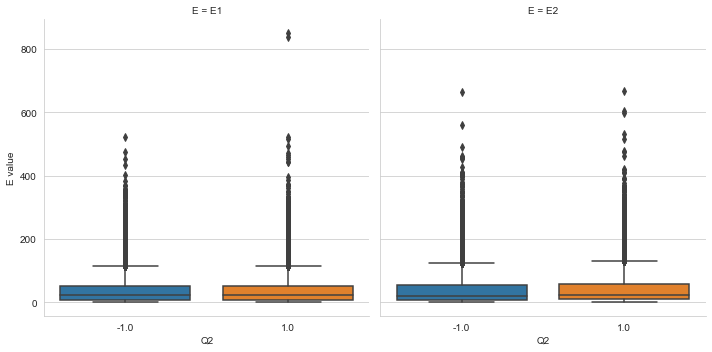

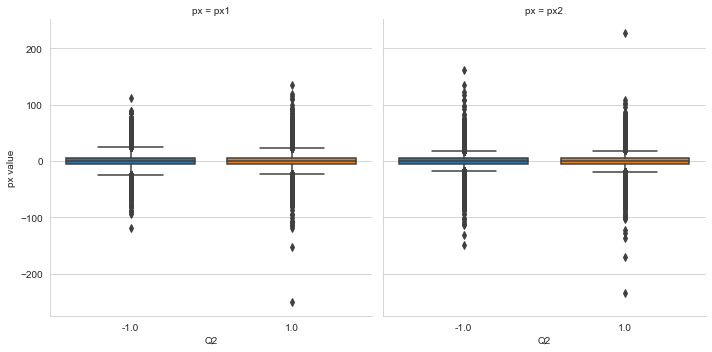

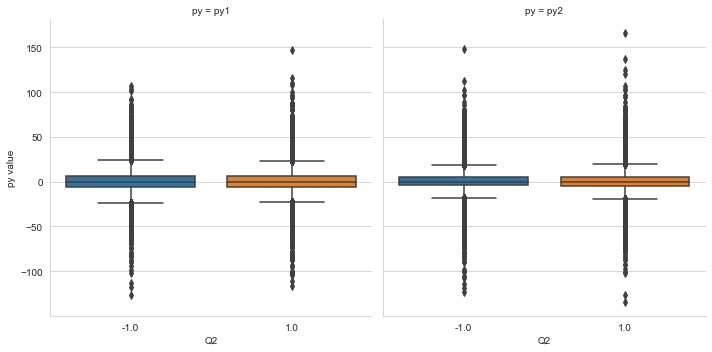

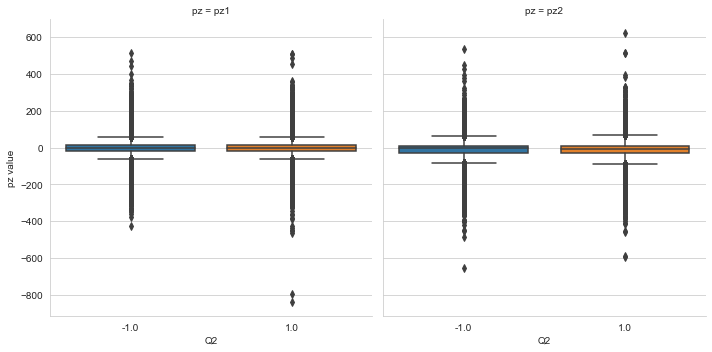

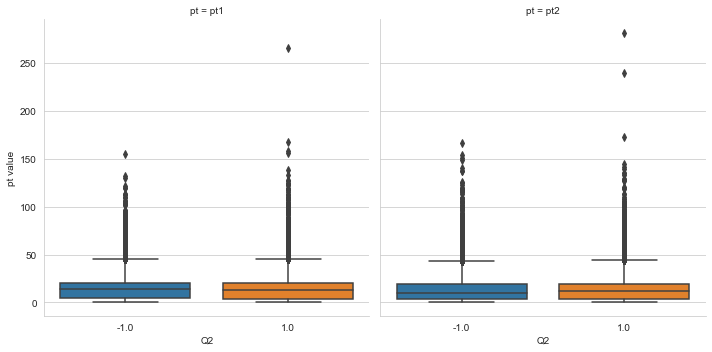

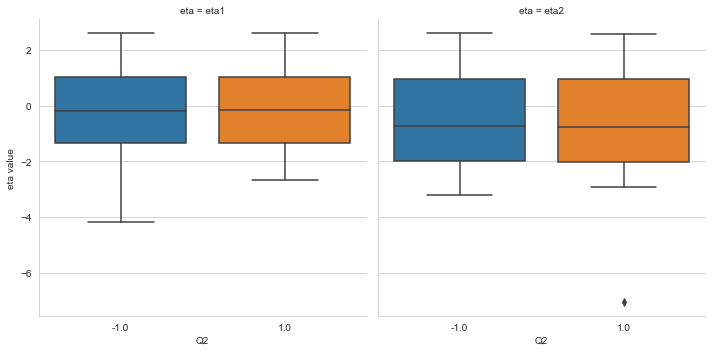

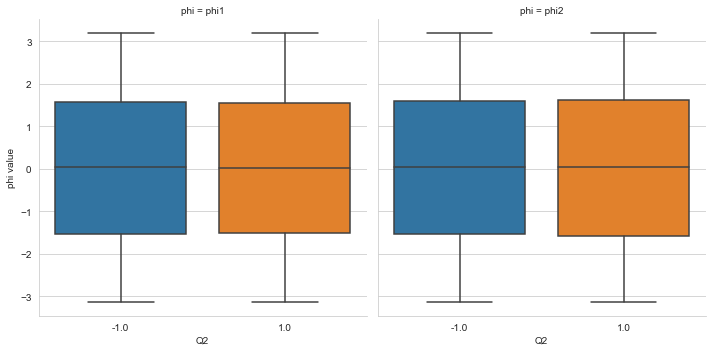

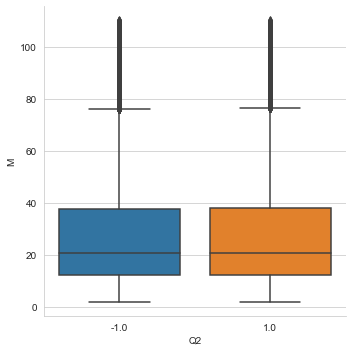

In [ ]:
features = ['px', 'py', 'pz', 'pt', 'eta', 'phi']
data_cat = pd.melt(data, id_vars='Q2', value_vars=['E1', 'E2'], var_name='E', value_name='E value')
for feature in features:
    data_cat[[feature, (feature+' value')]] = pd.melt(data, id_vars='Q2', value_vars=[(feature+'1'), (feature+'2')], var_name=feature, value_name=(feature+' value')).drop(columns='Q2')

features = ['E', 'px', 'py', 'pz', 'pt', 'eta', 'phi']
for feature in features:
    data_f = data_cat[['Q2', feature, (feature+' value')]]
    sns.catplot(y=(feature+' value'), x='Q2', col=feature, data=data_f, kind='box')
sns.catplot(y='M', x='Q2', data=data, kind='box')

Построим график корреляции

<AxesSubplot:>

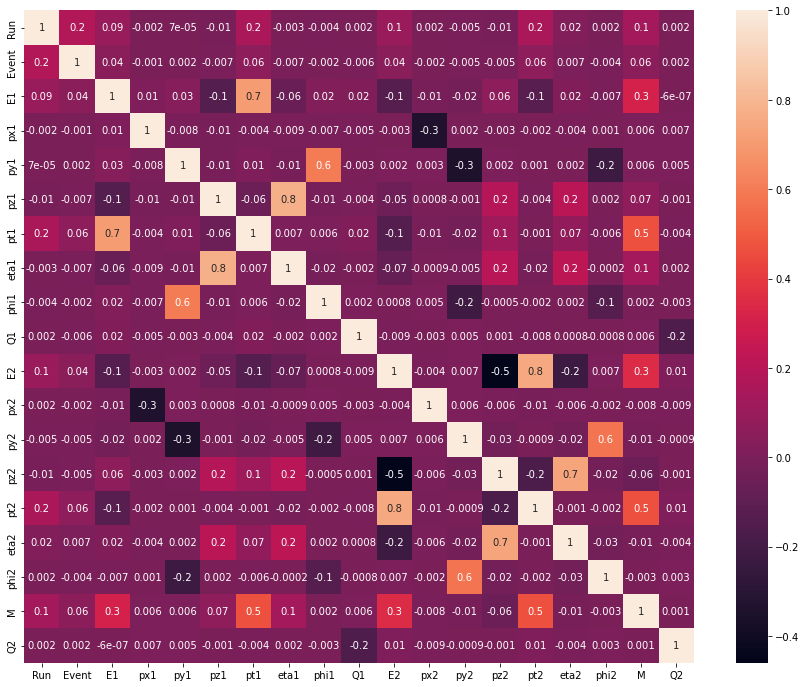

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot=True, fmt='.1g')

Отдельно посмотрим на зависимось Q2 с другими признаками

In [ ]:
corr_matrix = data.corr()
corr_matrix['Q2'].sort_values(ascending=False).round(6)

Q2      1.000000
pt2     0.011512
E2      0.010867
p2      0.010867
phi2    0.002865
eta1    0.001583
M       0.001294
E1     -0.000001
p1     -0.000001
phi1   -0.002556
pt1    -0.003654
eta2   -0.003743
Q1     -0.158531
Name: Q2, dtype: float64

Заметим, что заряд первого электрона 'Q1' играет наибольшую роль для заряда второго 'Q2'. Также чаще встречаются электроны с противоположными зарядами, тк значение кореляции в данной точке отрицательное

Посмотрим численное отличие столкновений электронов противоположных знаков от столкновений элекронов одиноковых знаков (+1, если оба имеют одинаковый знак, -1, если оба имеют разные знаки)

(array([0, 1]), [Text(0, 0, '-1.0'), Text(1, 0, '1.0')])

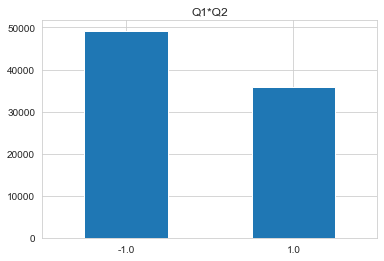

In [ ]:
sign = data.Q1 * data.Q2
sign.value_counts().plot(kind='bar')
plt.title('Q1*Q2')
plt.xticks(rotation=0)

Посмотрим плотность значений по каждому признаку

Text(0.5, 0, 'Feature')

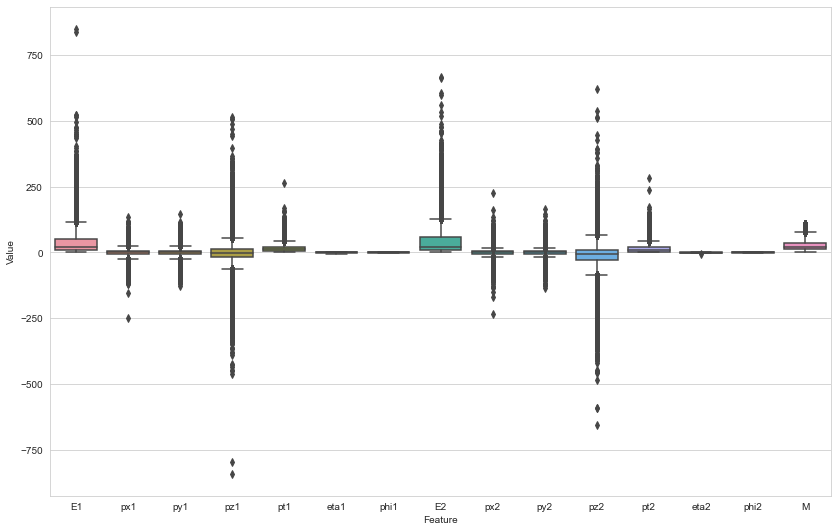

In [ ]:
plt.figure(figsize = (14,9))
sns.boxplot(data = data.drop(columns=['Q1', 'Q2', 'Event', 'Run']))
plt.ylabel('Value')
plt.xlabel('Feature')

array([[<AxesSubplot:title={'center':'E1'}>,
        <AxesSubplot:title={'center':'E2'}>,
        <AxesSubplot:title={'center':'px1'}>,
        <AxesSubplot:title={'center':'px2'}>],
       [<AxesSubplot:title={'center':'py1'}>,
        <AxesSubplot:title={'center':'py2'}>,
        <AxesSubplot:title={'center':'pz1'}>,
        <AxesSubplot:title={'center':'pz2'}>],
       [<AxesSubplot:title={'center':'pt1'}>,
        <AxesSubplot:title={'center':'pt2'}>,
        <AxesSubplot:title={'center':'eta1'}>,
        <AxesSubplot:title={'center':'eta2'}>],
       [<AxesSubplot:title={'center':'phi1'}>,
        <AxesSubplot:title={'center':'phi2'}>,
        <AxesSubplot:title={'center':'M'}>, <AxesSubplot:>]], dtype=object)

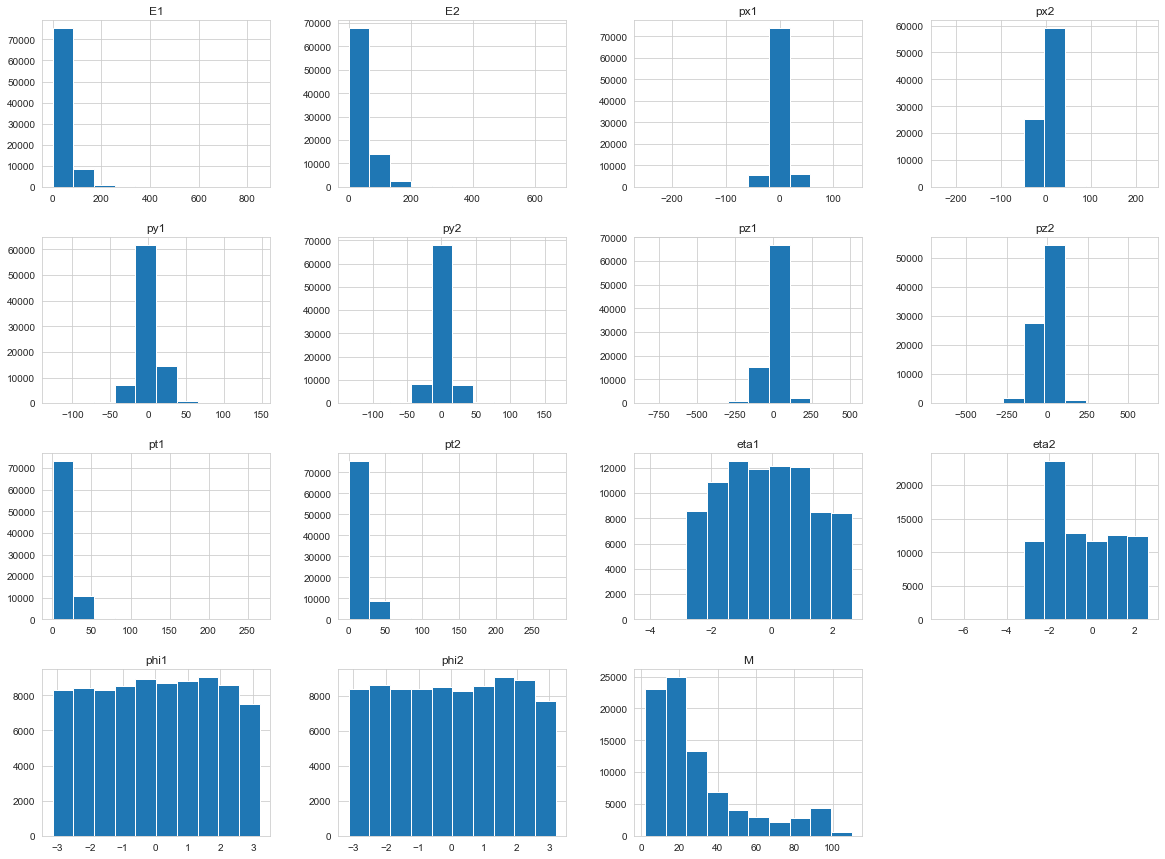

In [ ]:
data_hist= data[['E1', 'E2', 'px1', 'px2', 'py1', 'py2', 'pz1', 'pz2', 'pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'M']]
data_hist.hist(figsize = (20,15))

Посмотрим на расброс данных по каждому признаку отдельно

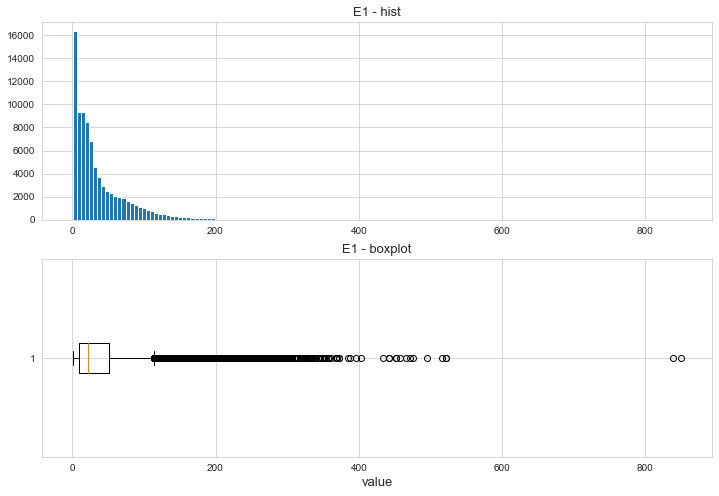

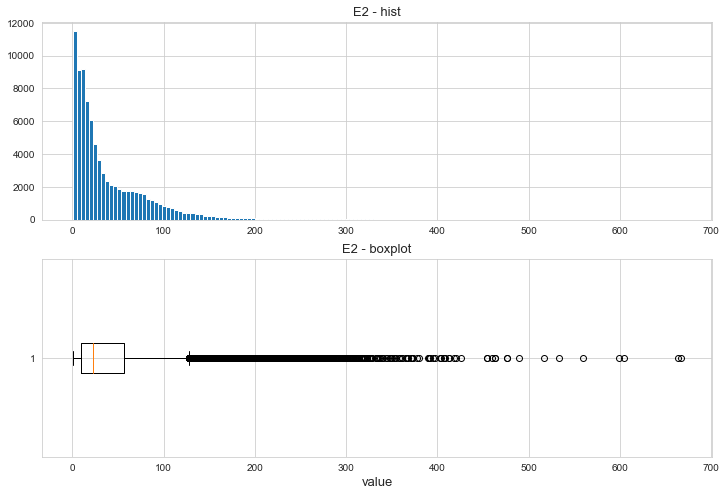

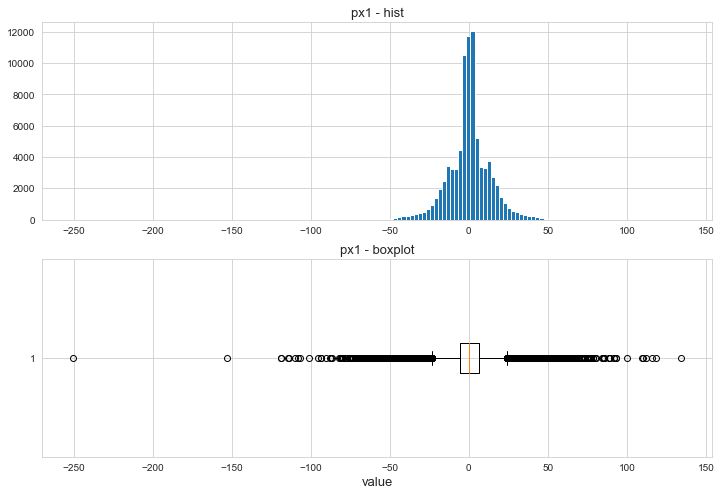

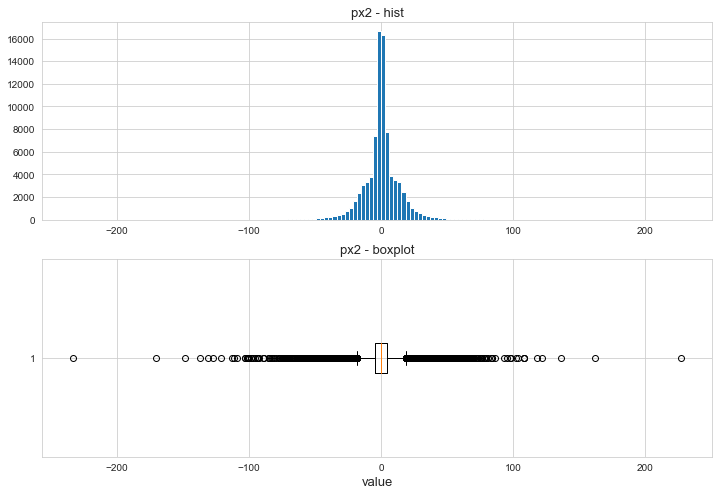

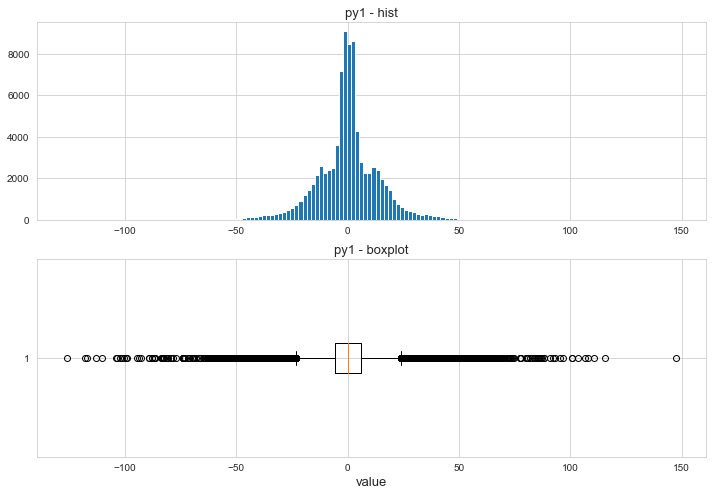

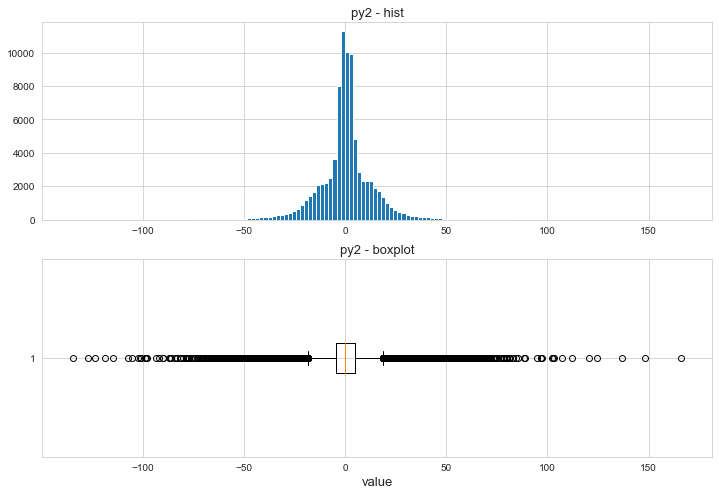

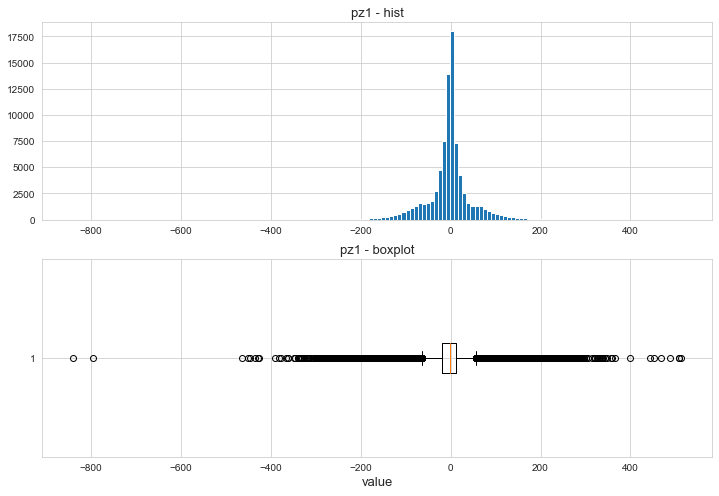

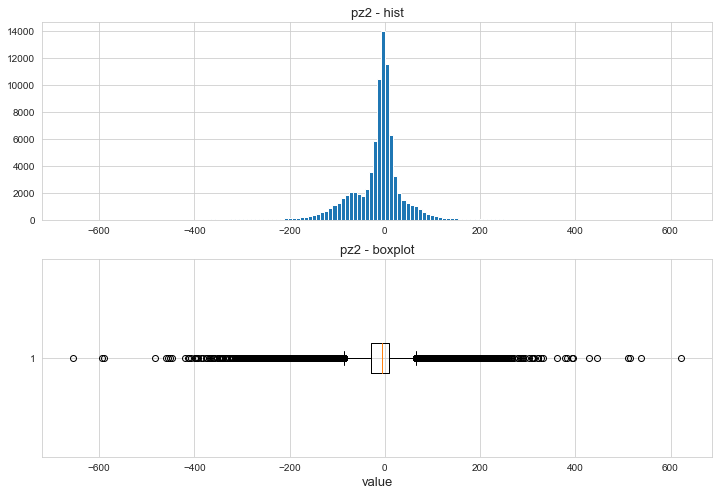

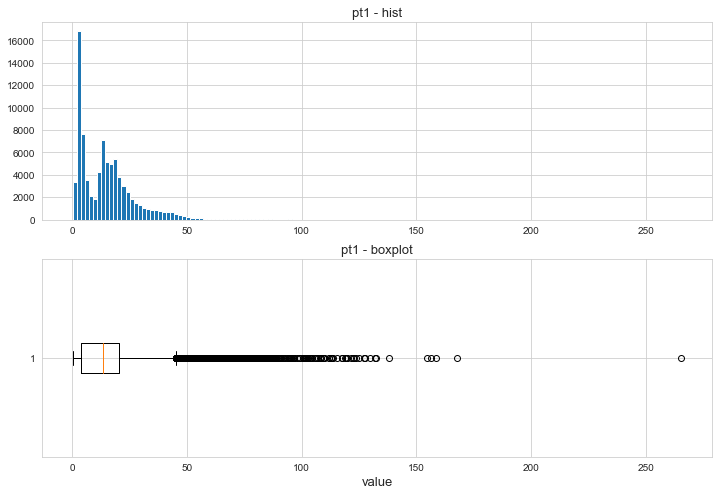

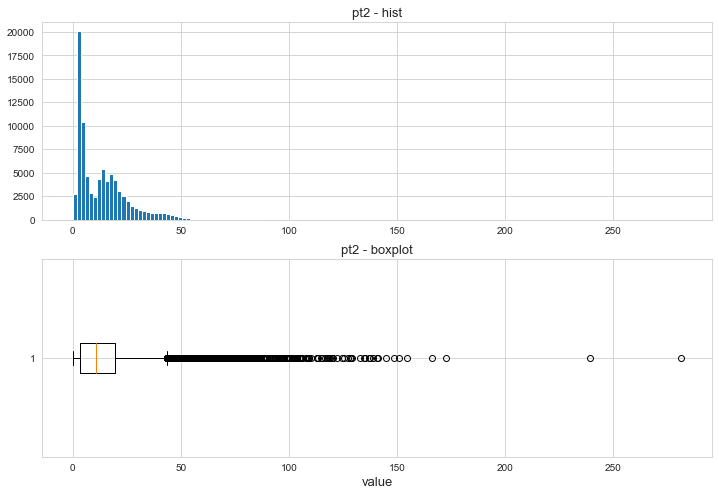

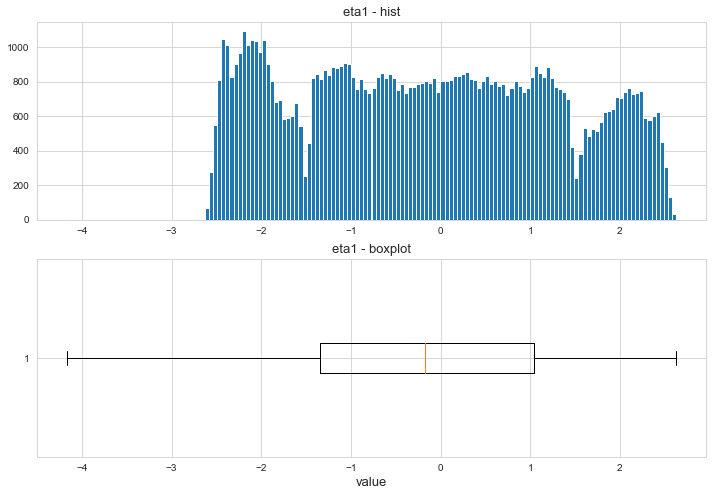

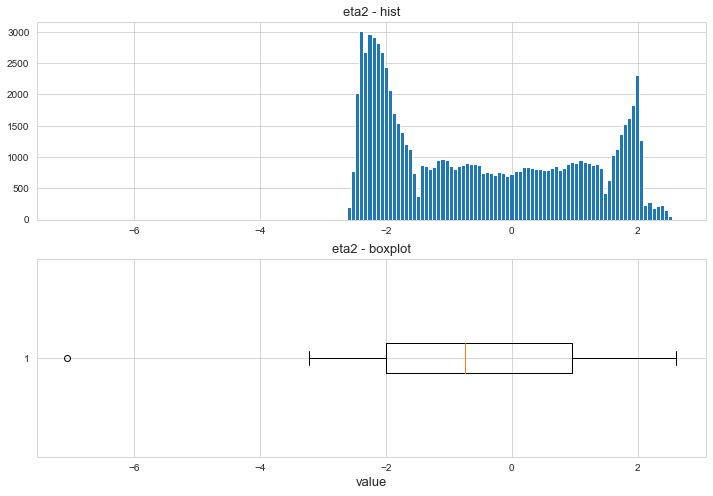

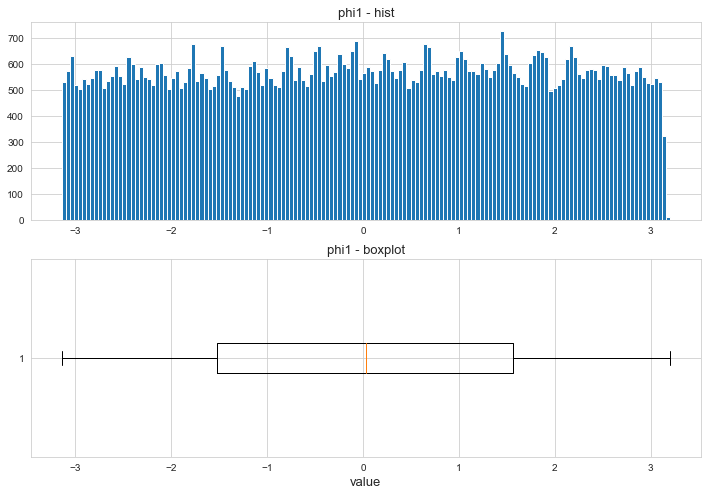

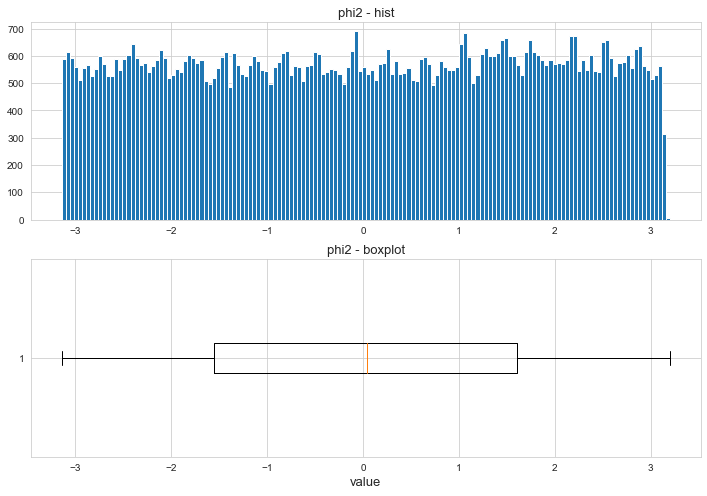

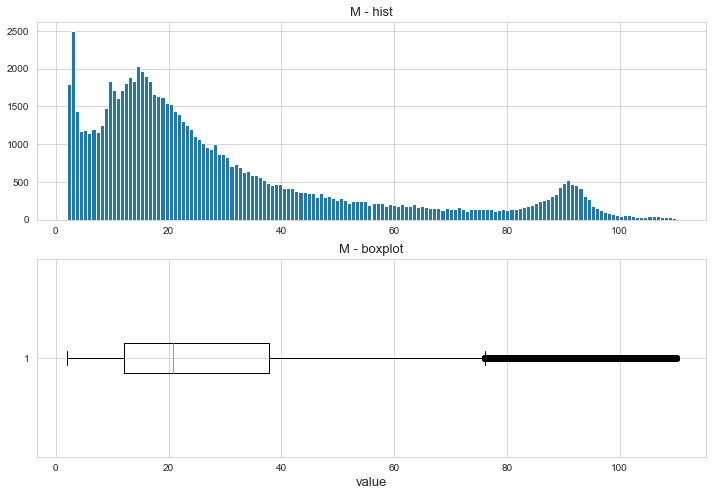

In [ ]:
features = ['E1', 'E2', 'px1', 'px2', 'py1', 'py2', 'pz1', 'pz2', 'pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'M']

for feature in features:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
    
    ax1.hist(data[feature], bins=150)
    ax1.set_title(feature + ' - hist', fontsize=13)  

    ax2.boxplot(data[feature], vert=False) 
    ax2.set_title(feature + ' - boxplot', fontsize=13)
    ax2.set_xlabel('value', fontsize=13) 
    plt.show()

Видим, что в данных присутсвуют небольшие выбросы. Устраним их

In [ ]:
df = data.copy()

In [ ]:
df = df[
        (df['E1'] <= df['E1'].quantile(0.9925))&
        (df['px1'] >= df['px1'].quantile(0.0025))&
        (df['px1'] <= df['px1'].quantile(0.9925))&
        (df['py1'] >= df['py1'].quantile(0.0025))&
        (df['py1'] <= df['py1'].quantile(0.9925))&
        (df['pz1'] >= df['pz1'].quantile(0.0025))&
        (df['pz1'] <= df['pz1'].quantile(0.9925))&
        (df['pt1'] <= df['pt1'].quantile(0.9925))&
        (df['E2'] <= df['E2'].quantile(0.9925))&
        (df['px2'] >= df['px2'].quantile(0.0025))&
        (df['px2'] <= df['px2'].quantile(0.9925))&
        (df['py2'] >= df['py2'].quantile(0.0025))&
        (df['py2'] <= df['py2'].quantile(0.9925))&
        (df['pz2'] >= df['pz2'].quantile(0.0025))&
        (df['pz2'] <= df['pz2'].quantile(0.9925))&
        (df['pt2'] <= df['pt2'].quantile(0.9925))&
        (df['eta2'] >= df['eta2'].quantile(0.0025))&
        (df['M'] <= df['M'].quantile(0.9925))
        ]

In [ ]:
data.columns

Index(['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2',
       'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'M', 'Q2'],
      dtype='object')

## Разделим данные на обучающие и тренировочные 

In [9]:
df = data.copy()

In [ ]:
y = df['Q2']
x = df.drop(columns = ['Q2'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

## Построим модели

### LogisticRegression +

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 0, solver='newton-cg')
lr.fit(x_train, y_train)

pred = lr.predict(x_test)
pred_train = lr.predict(x_train)
# solver='newton-cg' - score on test: 0.5775882352941176

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.5797478781460071
    f1_score: 0.5797483842648605
score on test: 
    accuracy_score: 0.5767239350435397
    f1_score: 0.5767278914273357


(with IterativeImputer, without drop_columns('Run','Event'), without drop_anomalies):
score on train:
    accuracy_score: 0.57976258770575
    f1_score: 0.5797632656594854
score on test: 
    accuracy_score: 0.5767239350435397
    f1_score: 0.5767278738464077

In [ ]:
cross_val_score(lr, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Use

0.555669794799681

### LogisticRegressionCV +

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

lr_cv = LogisticRegressionCV(random_state = 0, solver='newton-cg', n_jobs=-1)
lr_cv.fit(x_train, y_train)

pred = lr_cv.predict(x_test)
pred_train = lr_cv.predict(x_train)

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWa

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.57976258770575
    f1_score: 0.5797632656594854
score on test: 
    accuracy_score: 0.5767827724170393
    f1_score: 0.5767866974878078


(with IterativeImputer, without drop_columns('Run','Event'), without drop_anomalies):
score on train:
    accuracy_score: 0.57976258770575
    f1_score: 0.5797632656594854
score on test: 
    accuracy_score: 0.5767827724170393
    f1_score: 0.5767866974878078

In [ ]:
cross_val_score(lr_cv, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Use

0.5751558465750676

### AdaBoostClassifier +

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=5,random_state=0), n_estimators=5, learning_rate=0.6)
adb.fit(x_train, y_train)

pred = adb.predict(x_test)
pred_train = adb.predict(x_train)

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.5957224600267714
    f1_score: 0.5952301259391302
score on test: 
    accuracy_score: 0.5790774299835255
    f1_score: 0.578566491701739


(with IterativeImputer, without drop_duplicates, without drop_columns('Run','Event'), without drop_anomalies):
score on train:
    accuracy_score: 0.5935895738640542
    f1_score: 0.5935906426418179
score on test: 
    accuracy_score: 0.5802541774535185
    f1_score: 0.5802417786060177

In [ ]:
cross_val_score(adb, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

0.5517215550768657

<BarContainer object of 18 artists>

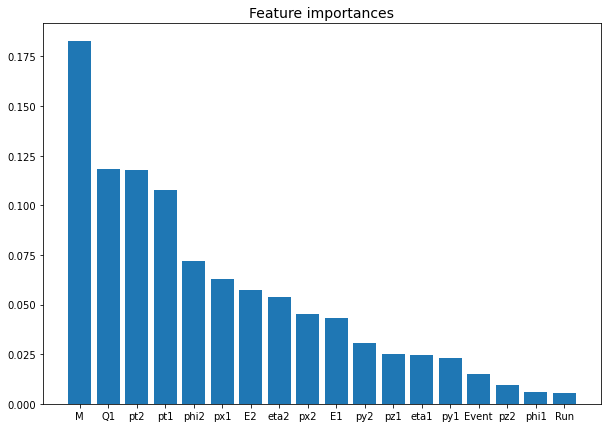

In [ ]:
importance = sorted(zip(x_train.columns, adb.feature_importances_), key = lambda val: val[1])[::-1]

# plot feature importance
plt.figure(figsize=(10,7))
plt.title('Feature importances', fontsize=14)
plt.bar([feature for feature, score in importance], [score for feature, score in importance])

### CatBoostClassifier +

- random_state / random_seed - это одно и тоже (позваляет давать одни и теже результаты от запуска к запуску)
- early_stopping_rounds - overfitting detector

In [ ]:
cbc = CatBoostClassifier(
    random_seed=0
)
cbc.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    verbose=False,
    plot=True
)
pred = cbc.predict(x_test)
pred_train = cbc.predict(x_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
# eval_metric='F1' (мы оцениваем тестовую выборку по результату F1, следовательно мы хотим, чтобы и модель училась, учитывала этот параметр)
# random_seed=0 (закрепим результат тренировки)

cbc = CatBoostClassifier(
    eval_metric='F1',
    iterations=800,
    learning_rate=0.01,
    leaf_estimation_method='Newton',
    random_seed=0
)
cbc.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    verbose=False,
    plot=True
)
pred = cbc.predict(x_test)
pred_train = cbc.predict(x_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.5833664298427548
    f1_score: 0.5833143510067463
score on test: 
    accuracy_score: 0.5784302188750294
    f1_score: 0.5783628796178328


(with IterativeImputer, without drop_columns('Run','Event'), without drop_anomalies):
score on train:
    accuracy_score: 0.5851904152508716
    f1_score: 0.5851902940845558
score on test: 
    accuracy_score: 0.5822546481525065
    f1_score: 0.5822585354892263

In [ ]:
cross_val_score(cbc, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

0:	learn: 0.5627238	total: 68.5ms	remaining: 54.8s
0:	learn: 0.5726530	total: 67.2ms	remaining: 53.7s
1:	learn: 0.5724335	total: 80.9ms	remaining: 32.3s
0:	learn: 0.5947750	total: 71ms	remaining: 56.7s
1:	learn: 0.5815342	total: 79.9ms	remaining: 31.9s
2:	learn: 0.5778538	total: 91.2ms	remaining: 24.2s
1:	learn: 0.5736917	total: 84.1ms	remaining: 33.5s
2:	learn: 0.5804375	total: 88.8ms	remaining: 23.6s
3:	learn: 0.5768877	total: 101ms	remaining: 20.1s
0:	learn: 0.6047416	total: 65.4ms	remaining: 52.2s
0:	learn: 0.5729298	total: 69.7ms	remaining: 55.7s
2:	learn: 0.5716027	total: 95.2ms	remaining: 25.3s
3:	learn: 0.5721396	total: 106ms	remaining: 21.1s
3:	learn: 0.5790857	total: 101ms	remaining: 20.1s
4:	learn: 0.5764008	total: 110ms	remaining: 17.6s
0:	learn: 0.5579494	total: 68ms	remaining: 54.3s
1:	learn: 0.5738610	total: 77.9ms	remaining: 31.1s
1:	learn: 0.5797724	total: 74.1ms	remaining: 29.6s
1:	learn: 0.5750551	total: 76ms	remaining: 30.3s
2:	learn: 0.5775000	total: 87.2ms	remaini

0.5619382839097977

<BarContainer object of 18 artists>

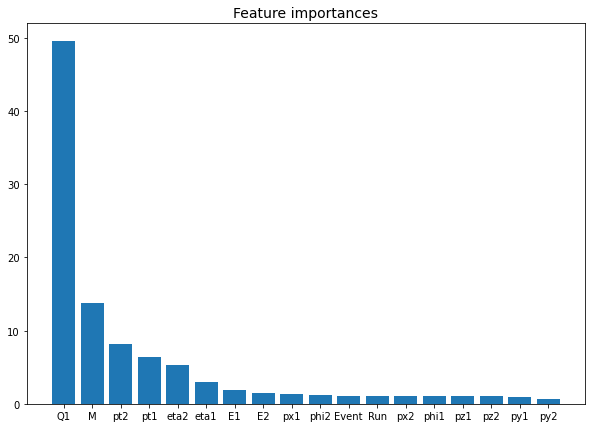

In [ ]:
importance = sorted(zip(x_train.columns, cbc.feature_importances_), key = lambda val: val[1])[::-1]

# plot feature importance
plt.figure(figsize=(10,7))
plt.title('Feature importances', fontsize=14)
plt.bar([feature for feature, score in importance], [score for feature, score in importance])

In [ ]:
df.drop(columns = ['Run','Event'], inplace=True)

Поработаем с компонентами импульса по осям

In [ ]:
df['p1'] = (df['px1']**2 + df['py1']**2 + df['pz1']**2)**0.5
df['p2'] = (df['px2']**2 + df['py2']**2 + df['pz2']**2)**0.5

In [ ]:
df.drop(columns=['px1', 'py1', 'pz1', 'px2', 'py2', 'pz2'], inplace=True)

Let's get absolute values of P1 and P2 vectors

In [ ]:
df.head()

,E1,pt1,eta1,phi1,Q1,E2,pt2,eta2,phi2,M,Q2,p1,p2
0,24.08500,20.62800,0.571144,1.795240,-1,2.57188,2.52255,0.197459,-2.59630,12.0101,1,24.084927,2.571885
1,22.94630,6.98534,-1.858470,2.304500,1,67.16120,14.04710,-2.246710,2.19832,4.0102,1,22.946287,67.161242
2,2.39342,1.96592,0.648077,-1.393620,1,33.86190,31.92390,0.346700,-2.88438,11.0103,1,2.393413,33.861855
3,80.32260,29.83510,1.647090,2.075850,1,22.38180,7.50892,1.755900,1.25826,12.0104,-1,80.322645,22.381786
4,3.20864,2.86791,-0.482756,-0.122994,1,27.96590,10.66770,-1.618370,-1.96111,11.0105,1,3.208644,27.965875


### XGBClassifier

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance

xgbc = XGBClassifier(eval_metric='mlogloss', random_state=0)
xgbc.fit(x_train,y_train)

pred = xgbc.predict(x_test)
pred_train = xgbc.predict(x_train)

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.7258285159525175
    f1_score: 0.725795691556088
score on test: 
    accuracy_score: 0.5724288067780654
    f1_score: 0.5723981551593122


(with IterativeImputer, without drop_columns('Run','Event'), without drop_anomalies):
score on train:
    accuracy_score: 0.7148487477757026
    f1_score: 0.7148217880497626
score on test: 
    accuracy_score: 0.5701176470588235
    f1_score: 0.5700551558542077

In [ ]:
cross_val_score(xgbc, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zhariko_o

0.5640386540662398

<BarContainer object of 18 artists>

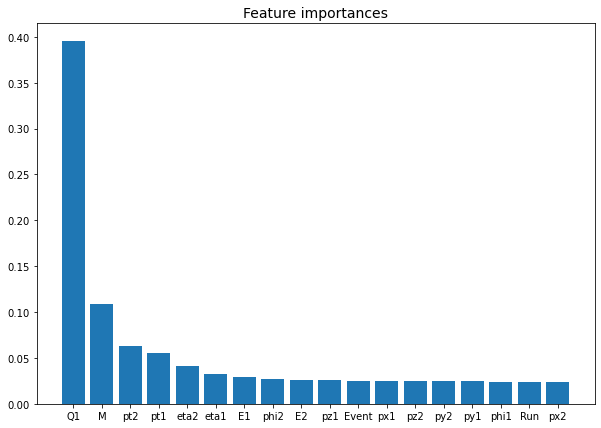

In [ ]:
importance = sorted(zip(x_train.columns, xgbc.feature_importances_), key = lambda val: val[1])[::-1]

# plot feature importance
plt.figure(figsize=(10,7))
plt.title('Feature importances', fontsize=14)
plt.bar([feature for feature, score in importance], [score for feature, score in importance])

In [ ]:
from sklearn.feature_selection import SelectFromModel

thresholds = sort(xgbc.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(xgbc, threshold=thresh, prefit=True)
	select_X_train = selection.transform(x_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(x_test)
	predictions = selection_model.predict(select_X_test)
	f1 = f1_score(y_test, predictions)
	print(f'Thresh={thresh}, n={select_X_train.shape[1]}, f1_score: {round(f1, 6)}')

Thresh=0.02150237187743187, n=18, f1_score: 0.562919
Thresh=0.02161289006471634, n=17, f1_score: 0.565941
Thresh=0.023987649008631706, n=16, f1_score: 0.570074
Thresh=0.024335011839866638, n=15, f1_score: 0.571207
Thresh=0.024942928925156593, n=14, f1_score: 0.567031
Thresh=0.02505922131240368, n=13, f1_score: 0.565872
Thresh=0.025207767263054848, n=12, f1_score: 0.562803
Thresh=0.02535075880587101, n=11, f1_score: 0.565997
Thresh=0.025647060945630074, n=10, f1_score: 0.567724
Thresh=0.026136845350265503, n=9, f1_score: 0.56075
Thresh=0.026232628151774406, n=8, f1_score: 0.564278
Thresh=0.02661353163421154, n=7, f1_score: 0.569249
Thresh=0.029117217287421227, n=6, f1_score: 0.565048
Thresh=0.041840460151433945, n=5, f1_score: 0.565701
Thresh=0.056418031454086304, n=4, f1_score: 0.566024
Thresh=0.06713315844535828, n=3, f1_score: 0.558722
Thresh=0.1041628047823906, n=2, f1_score: 0.563857
Thresh=0.4046996533870697, n=1, f1_score: 0.574108


### GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(x_train, y_train)

pred = gbc.predict(x_test)
pred_train = gbc.predict(x_train)

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.5938249268199403
    f1_score: 0.5938101817913092
score on test: 
    accuracy_score: 0.5773711461520358
    f1_score: 0.5773706765059089


(with IterativeImputer, without drop_columns('Run','Event'), without drop_anomalies):
score on train:
    accuracy_score: 0.5914498742628568
    f1_score: 0.5913914591660205
score on test: 
    accuracy_score: 0.5814117647058824
    f1_score: 0.581393027892632

In [ ]:
cross_val_score(gbc, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

0.5649175534377164

In [ ]:
importance = sorted(zip(x_train.columns, gbc.feature_importances_), key = lambda val: val[1])[::-1]

# plot feature importance
plt.figure(figsize=(10,7))
plt.title('Feature importances', fontsize=14)
plt.bar([feature for feature, score in importance], [score for feature, score in importance])

NameError: name 'gbc' is not defined

### RandomForestClassifier +

Подберем гиперпараметры

In [ ]:
rfc = RandomForestClassifier(random_state = 0, n_jobs = -1)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt', 'auto']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(x_train, y_train)
rs.best_params_

Обучим модель с получившимися гиперпараметрами

In [ ]:
rfc = RandomForestClassifier(n_jobs = -1, 
                             n_estimators = 400,
                             min_samples_split = 12,
                             min_samples_leaf = 39,
                             max_features = 'sqrt',
                             max_depth = 11,
                             bootstrap = True,
                             random_state = 0)
rfc.fit(x_train, y_train)

pred = rfc.predict(x_test)
pred_train = rfc.predict(x_train)

Оцениваем результат

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.6407190032802318
    f1_score: 0.6407120809622039
score on test: 
    accuracy_score: 0.5763120734290421
    f1_score: 0.5763004787580835


(with IterativeImputer, without drop_columns('Run','Event'), without drop_anomalies):
score on train:
    accuracy_score: 0.6384211532522537
    f1_score: 0.6384172471256591
score on test: 
    accuracy_score: 0.5804117647058824
    f1_score: 0.5804081362304231

In [ ]:
cross_val_score(rfc, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

0.5605185849503764

Feature importances

<BarContainer object of 18 artists>

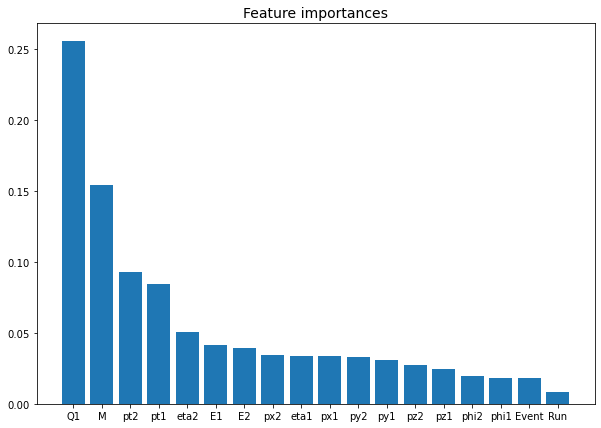

In [ ]:
importance = sorted(zip(x_train.columns, rfc.feature_importances_), key = lambda val: val[1])[::-1]

# plot feature importance
plt.figure(figsize=(10,7))
plt.title('Feature importances', fontsize=14)
plt.bar([feature for feature, score in importance], [score for feature, score in importance])


### LGBMClassifier

In [ ]:
import lightgbm as lgb

lgbc = lgb.LGBMClassifier(random_state = 0, num_leaves=4, n_estimators=1000, n_jobs=-1)
lgbc.fit(x_train, y_train)

pred = lgbc.predict(x_test)
pred_train = lgbc.predict(x_train)

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.62122883662092
    f1_score: 0.6212297574695606
score on test: 
    accuracy_score: 0.5782537067545305
    f1_score: 0.5782559668629483


(with IterativeImputer, without drop_columns('Run','Event'), without drop_anomalies):

score on train:
    accuracy_score: 0.6226262447964932
    f1_score: 0.6226194989199653
score on test: 
    accuracy_score: 0.5761355613085432
    f1_score: 0.5761286764776363

In [ ]:
cross_val_score(lgbc, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

0.5614344088875429

Feature importances

<BarContainer object of 18 artists>

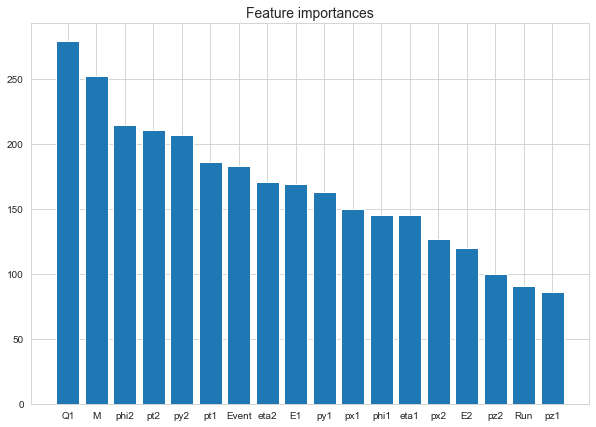

In [ ]:
importance = sorted(zip(x_train.columns, lgbc.feature_importances_), key = lambda val: val[1])[::-1]

# plot feature importance
plt.figure(figsize=(10,7))
plt.title('Feature importances', fontsize=14)
plt.bar([feature for feature, score in importance], [score for feature, score in importance])

###  VotingClassifier

RandomForestClassifier

In [ ]:
from sklearn.ensemble import VotingClassifier

vc=VotingClassifier(
                    estimators=[('lr',lr_cv), ('adb',adb), ('cbc',cbc),('xgbc', xgbc), ('gbc', gbc), ('rfc',rfc), ('lgbc',lgbc)],
                    voting='hard'
                    )
vc.fit(x_train, y_train)

pred = vc.predict(x_test)
pred_train = vc.predict(x_train)

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWa

0:	learn: 0.5703012	total: 11.1ms	remaining: 8.84s
1:	learn: 0.5794186	total: 21.9ms	remaining: 8.74s
2:	learn: 0.5796308	total: 34ms	remaining: 9.04s
3:	learn: 0.5796214	total: 45.7ms	remaining: 9.1s
4:	learn: 0.5796338	total: 56.8ms	remaining: 9.04s
5:	learn: 0.5795587	total: 67.5ms	remaining: 8.94s
6:	learn: 0.5795587	total: 78.6ms	remaining: 8.9s
7:	learn: 0.5796299	total: 90ms	remaining: 8.91s
8:	learn: 0.5796927	total: 101ms	remaining: 8.9s
9:	learn: 0.5799255	total: 112ms	remaining: 8.87s
10:	learn: 0.5799255	total: 124ms	remaining: 8.89s
11:	learn: 0.5798837	total: 135ms	remaining: 8.84s
12:	learn: 0.5796214	total: 146ms	remaining: 8.83s
13:	learn: 0.5796214	total: 157ms	remaining: 8.84s
14:	learn: 0.5796214	total: 168ms	remaining: 8.81s
15:	learn: 0.5796214	total: 179ms	remaining: 8.76s
16:	learn: 0.5796214	total: 190ms	remaining: 8.75s
17:	learn: 0.5796214	total: 202ms	remaining: 8.76s
18:	learn: 0.5796214	total: 213ms	remaining: 8.76s
19:	learn: 0.5796214	total: 225ms	remain

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.6191547886971743
    f1_score: 0.6191507289719269
score on test: 
    accuracy_score: 0.5776064956460344
    f1_score: 0.5776003760790454


In [ ]:
cross_val_score(vc, x_test, y_test, cv=10, scoring='f1', n_jobs=-1).mean()

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/lin

0:	learn: 0.6047416	total: 37.1ms	remaining: 29.7s
1:	learn: 0.5797724	total: 62.5ms	remaining: 24.9s
2:	learn: 0.5742405	total: 69.9ms	remaining: 18.6s
3:	learn: 0.5733779	total: 83.4ms	remaining: 16.6s
4:	learn: 0.5712967	total: 91.6ms	remaining: 14.6s
5:	learn: 0.5714474	total: 99.1ms	remaining: 13.1s
6:	learn: 0.5716543	total: 106ms	remaining: 12.1s
7:	learn: 0.5713344	total: 114ms	remaining: 11.3s
8:	learn: 0.5712588	total: 121ms	remaining: 10.7s
9:	learn: 0.5711074	total: 129ms	remaining: 10.2s
10:	learn: 0.5723162	total: 154ms	remaining: 11.1s
11:	learn: 0.5723946	total: 164ms	remaining: 10.8s
12:	learn: 0.5714096	total: 174ms	remaining: 10.6s
13:	learn: 0.5723732	total: 187ms	remaining: 10.5s
14:	learn: 0.5736557	total: 197ms	remaining: 10.3s
15:	learn: 0.5726366	total: 204ms	remaining: 10s
16:	learn: 0.5726930	total: 220ms	remaining: 10.1s
17:	learn: 0.5726541	total: 225ms	remaining: 9.79s


/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/

18:	learn: 0.5728995	total: 233ms	remaining: 9.58s
19:	learn: 0.5727105	total: 277ms	remaining: 10.8s
20:	learn: 0.5728245	total: 284ms	remaining: 10.5s
21:	learn: 0.5727501	total: 297ms	remaining: 10.5s
22:	learn: 0.5729029	total: 319ms	remaining: 10.8s
23:	learn: 0.5725438	total: 333ms	remaining: 10.8s
24:	learn: 0.5717312	total: 362ms	remaining: 11.2s
25:	learn: 0.5719966	total: 372ms	remaining: 11.1s
0:	learn: 0.5726530	total: 25.3ms	remaining: 20.2s
26:	learn: 0.5720336	total: 388ms	remaining: 11.1s
0:	learn: 0.5697792	total: 10.7ms	remaining: 8.52s
27:	learn: 0.5722413	total: 395ms	remaining: 10.9s
1:	learn: 0.5815342	total: 43.7ms	remaining: 17.4s
28:	learn: 0.5729408	total: 403ms	remaining: 10.7s
2:	learn: 0.5804375	total: 55.6ms	remaining: 14.8s
1:	learn: 0.5778042	total: 30.1ms	remaining: 12s
29:	learn: 0.5729780	total: 424ms	remaining: 10.9s
2:	learn: 0.5789300	total: 39.2ms	remaining: 10.4s
3:	learn: 0.5790857	total: 70.6ms	remaining: 14s
30:	learn: 0.5730322	total: 428ms	r

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/

32:	learn: 0.5731087	total: 455ms	remaining: 10.6s
4:	learn: 0.5795058	total: 74.5ms	remaining: 11.8s
6:	learn: 0.5782769	total: 108ms	remaining: 12.2s
33:	learn: 0.5736168	total: 464ms	remaining: 10.4s
7:	learn: 0.5782626	total: 119ms	remaining: 11.8s
34:	learn: 0.5738798	total: 474ms	remaining: 10.4s
8:	learn: 0.5786602	total: 126ms	remaining: 11.1s
35:	learn: 0.5727867	total: 490ms	remaining: 10.4s
5:	learn: 0.5800501	total: 111ms	remaining: 14.6s
6:	learn: 0.5791903	total: 123ms	remaining: 14s
9:	learn: 0.5789785	total: 158ms	remaining: 12.5s
7:	learn: 0.5775839	total: 136ms	remaining: 13.5s
10:	learn: 0.5788297	total: 168ms	remaining: 12.1s
8:	learn: 0.5786762	total: 148ms	remaining: 13s
11:	learn: 0.5789197	total: 180ms	remaining: 11.8s
36:	learn: 0.5728809	total: 538ms	remaining: 11.1s
37:	learn: 0.5723528	total: 547ms	remaining: 11s
12:	learn: 0.5785982	total: 193ms	remaining: 11.7s
38:	learn: 0.5722020	total: 555ms	remaining: 10.8s
9:	learn: 0.5780301	total: 176ms	remaining: 1

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


782:	learn: 0.6543717	total: 9.9s	remaining: 215ms
729:	learn: 0.6481231	total: 9.86s	remaining: 946ms
774:	learn: 0.6525602	total: 10.3s	remaining: 334ms
759:	learn: 0.6513343	total: 9.91s	remaining: 521ms
783:	learn: 0.6540118	total: 9.9s	remaining: 202ms
702:	learn: 0.6419232	total: 10.3s	remaining: 1.43s
787:	learn: 0.6538306	total: 10.6s	remaining: 161ms
793:	learn: 0.6571371	total: 10.5s	remaining: 79.5ms
730:	learn: 0.6481632	total: 9.88s	remaining: 932ms
775:	learn: 0.6521916	total: 10.4s	remaining: 320ms
784:	learn: 0.6541930	total: 9.92s	remaining: 190ms
703:	learn: 0.6423318	total: 10.4s	remaining: 1.41s
794:	learn: 0.6574548	total: 10.5s	remaining: 66.2ms
731:	learn: 0.6477979	total: 9.89s	remaining: 919ms
788:	learn: 0.6536001	total: 10.6s	remaining: 147ms
785:	learn: 0.6542836	total: 9.93s	remaining: 177ms
704:	learn: 0.6422393	total: 10.4s	remaining: 1.4s
732:	learn: 0.6482032	total: 9.9s	remaining: 905ms
795:	learn: 0.6575896	total: 10.6s	remaining: 53.1ms
776:	learn: 0

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zhariko_o

785:	learn: 0.6523273	total: 10.5s	remaining: 188ms
744:	learn: 0.6495784	total: 10.1s	remaining: 743ms
795:	learn: 0.6559053	total: 10.1s	remaining: 50.8ms
774:	learn: 0.6539081	total: 10.1s	remaining: 326ms
786:	learn: 0.6523716	total: 10.5s	remaining: 174ms
745:	learn: 0.6495381	total: 10.1s	remaining: 729ms
715:	learn: 0.6428182	total: 10.5s	remaining: 1.24s
787:	learn: 0.6525544	total: 10.6s	remaining: 161ms
746:	learn: 0.6500708	total: 10.1s	remaining: 715ms
775:	learn: 0.6548506	total: 10.1s	remaining: 313ms
796:	learn: 0.6555413	total: 10.1s	remaining: 38.1ms
716:	learn: 0.6431004	total: 10.6s	remaining: 1.22s
776:	learn: 0.6552095	total: 10.1s	remaining: 300ms
797:	learn: 0.6559494	total: 10.1s	remaining: 25.4ms
717:	learn: 0.6432900	total: 10.6s	remaining: 1.21s
788:	learn: 0.6528287	total: 10.6s	remaining: 147ms
747:	learn: 0.6502968	total: 10.1s	remaining: 701ms
777:	learn: 0.6551632	total: 10.1s	remaining: 287ms
798:	learn: 0.6563089	total: 10.1s	remaining: 12.7ms
748:	lea

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


796:	learn: 0.6560150	total: 10.3s	remaining: 38.8ms
765:	learn: 0.6518219	total: 10.3s	remaining: 456ms
735:	learn: 0.6454601	total: 10.7s	remaining: 934ms
797:	learn: 0.6560215	total: 10.3s	remaining: 25.8ms
766:	learn: 0.6520478	total: 10.3s	remaining: 442ms
736:	learn: 0.6457326	total: 10.8s	remaining: 919ms
798:	learn: 0.6567384	total: 10.3s	remaining: 12.9ms
767:	learn: 0.6517749	total: 10.3s	remaining: 428ms
737:	learn: 0.6456929	total: 10.8s	remaining: 904ms
768:	learn: 0.6517749	total: 10.3s	remaining: 415ms
799:	learn: 0.6570489	total: 10.3s	remaining: 0us
738:	learn: 0.6458206	total: 10.8s	remaining: 889ms
769:	learn: 0.6520888	total: 10.3s	remaining: 401ms
739:	learn: 0.6456317	total: 10.8s	remaining: 874ms
770:	learn: 0.6523646	total: 10.3s	remaining: 388ms
740:	learn: 0.6461811	total: 10.8s	remaining: 860ms
771:	learn: 0.6523617	total: 10.3s	remaining: 374ms
741:	learn: 0.6464495	total: 10.8s	remaining: 845ms
772:	learn: 0.6527722	total: 10.3s	remaining: 361ms
742:	learn:

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


769:	learn: 0.6493595	total: 11.1s	remaining: 434ms
770:	learn: 0.6499966	total: 11.2s	remaining: 420ms
771:	learn: 0.6499012	total: 11.2s	remaining: 406ms
772:	learn: 0.6499046	total: 11.2s	remaining: 391ms
773:	learn: 0.6501329	total: 11.2s	remaining: 376ms
774:	learn: 0.6501329	total: 11.2s	remaining: 362ms
775:	learn: 0.6503134	total: 11.2s	remaining: 347ms
776:	learn: 0.6504054	total: 11.2s	remaining: 333ms
777:	learn: 0.6503134	total: 11.3s	remaining: 318ms
778:	learn: 0.6502658	total: 11.3s	remaining: 304ms
779:	learn: 0.6504940	total: 11.3s	remaining: 289ms
780:	learn: 0.6506779	total: 11.3s	remaining: 274ms
781:	learn: 0.6507223	total: 11.3s	remaining: 260ms
782:	learn: 0.6507634	total: 11.3s	remaining: 246ms
783:	learn: 0.6508207	total: 11.3s	remaining: 231ms
784:	learn: 0.6507255	total: 11.3s	remaining: 217ms
785:	learn: 0.6505926	total: 11.3s	remaining: 202ms
786:	learn: 0.6504973	total: 11.4s	remaining: 188ms
787:	learn: 0.6509505	total: 11.4s	remaining: 173ms
788:	learn: 

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/zha

0:	learn: 0.5700114	total: 7.82ms	remaining: 6.25s
1:	learn: 0.5789612	total: 14.7ms	remaining: 5.86s
2:	learn: 0.5764348	total: 21.3ms	remaining: 5.67s
3:	learn: 0.5780735	total: 30.3ms	remaining: 6.02s
4:	learn: 0.5795118	total: 38.1ms	remaining: 6.05s
5:	learn: 0.5801054	total: 46ms	remaining: 6.09s
6:	learn: 0.5797711	total: 54.2ms	remaining: 6.14s
7:	learn: 0.5805138	total: 61.8ms	remaining: 6.12s
8:	learn: 0.5798187	total: 70.6ms	remaining: 6.21s
9:	learn: 0.5802769	total: 78.8ms	remaining: 6.22s
10:	learn: 0.5803952	total: 87ms	remaining: 6.24s
11:	learn: 0.5802380	total: 94.8ms	remaining: 6.22s
12:	learn: 0.5811708	total: 103ms	remaining: 6.22s
13:	learn: 0.5810731	total: 111ms	remaining: 6.25s
14:	learn: 0.5811663	total: 118ms	remaining: 6.2s
15:	learn: 0.5817585	total: 127ms	remaining: 6.21s
16:	learn: 0.5817967	total: 134ms	remaining: 6.17s
17:	learn: 0.5807806	total: 140ms	remaining: 6.07s
18:	learn: 0.5806748	total: 148ms	remaining: 6.1s
19:	learn: 0.5805435	total: 157ms	r

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


773:	learn: 0.6539802	total: 7.22s	remaining: 242ms
774:	learn: 0.6539363	total: 7.23s	remaining: 233ms
775:	learn: 0.6538462	total: 7.24s	remaining: 224ms
776:	learn: 0.6541117	total: 7.24s	remaining: 214ms
777:	learn: 0.6542920	total: 7.25s	remaining: 205ms
778:	learn: 0.6543822	total: 7.26s	remaining: 196ms
779:	learn: 0.6542945	total: 7.27s	remaining: 187ms
780:	learn: 0.6547866	total: 7.28s	remaining: 177ms
781:	learn: 0.6546088	total: 7.29s	remaining: 168ms
782:	learn: 0.6548744	total: 7.3s	remaining: 159ms
783:	learn: 0.6545601	total: 7.31s	remaining: 149ms
784:	learn: 0.6548281	total: 7.32s	remaining: 140ms
785:	learn: 0.6546064	total: 7.33s	remaining: 131ms
786:	learn: 0.6547428	total: 7.34s	remaining: 121ms
787:	learn: 0.6549692	total: 7.34s	remaining: 112ms
788:	learn: 0.6555972	total: 7.36s	remaining: 103ms
789:	learn: 0.6558211	total: 7.36s	remaining: 93.2ms
790:	learn: 0.6560011	total: 7.37s	remaining: 83.9ms
791:	learn: 0.6561810	total: 7.38s	remaining: 74.6ms
792:	learn

/Users/zhariko_ov/opt/anaconda3/envs/ML-FreeCodeCamp/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5652609890444609

### Tensorflow 2

In [10]:
import tensorflow as tf
from keras import layers

In [11]:
dataframe = df.copy()

In [12]:
dataframe['target'] = dataframe.Q2
dataframe.drop(columns='Q2', inplace=True)

In [13]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [14]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [15]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [16]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of M:', train_features['M'])
print('A batch of targets:', label_batch )

Every feature: ['Run', 'Event', 'E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'M', 'target']
A batch of M: tf.Tensor(
[[66.6234 ]
 [ 2.85423]
 [27.2826 ]
 [79.135  ]
 [ 3.23633]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([ 1. -1. -1. -1.  1.], shape=(5,), dtype=float64)


In [17]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [18]:
photo_count_col = train_features['M']
layer = get_normalization_layer('M', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.4788468 ],
       [-1.056088  ],
       [-0.08501796],
       [ 1.9762046 ],
       [-1.0408988 ]], dtype=float32)>

In [19]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [20]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

KeyError: ignored

### Опыты 1

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=17)

tree.fit(x_train, y_train)

pred = evc.predict(x_test)
pred_train = evc.predict(x_train)

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.6333936425282791
    f1_score: 0.6333796429938237
score on test: 
    accuracy_score: 0.5770769592845375
    f1_score: 0.5770785756411754


In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': range(1,11), 'max_features': range(4,19)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(x_train, y_train)

pred = tree_grid.predict(x_test)
pred_train = tree_grid.predict(x_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [ ]:
tree_grid.best_params_

{'max_depth': 4, 'max_features': 15}

In [ ]:
tree_grid.best_score_

0.5799245028848432

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.5818366356294956
    f1_score: 0.5808438632332372
score on test: 
    accuracy_score: 0.5762532360555425
    f1_score: 0.5751647278578057


Испытываем

In [ ]:
tree = DecisionTreeClassifier(max_depth = 4, max_features = 15, random_state = 0)

tree.fit(x_train, y_train)
pred = tree.predict(x_test)
pred_train = tree.predict(x_train)

DecisionTreeClassifier(max_depth=4, max_features=15, random_state=0)

In [ ]:
print("score on train:")
print("    accuracy_score: " + str(accuracy_score(y_train, pred_train)))
print("    f1_score: " + str(f1_score(y_train, pred_train, average = 'weighted')))

print("score on test: ")
print("    accuracy_score: " + str(accuracy_score(y_test, pred)))
print("    f1_score: " + str(f1_score(y_test, pred, average = 'weighted')))

score on train:
    accuracy_score: 0.5818366356294956
    f1_score: 0.5808438632332372
score on test: 
    accuracy_score: 0.5762532360555425
    f1_score: 0.5751647278578057


<BarContainer object of 18 artists>

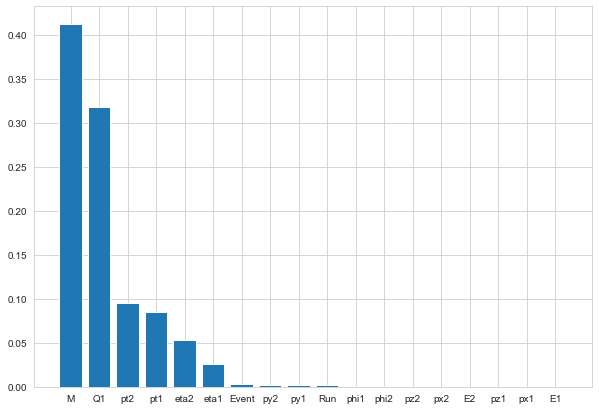

In [ ]:
importance = sorted(zip(x_train.columns, tree.feature_importances_), key = lambda val: val[1])[::-1]

# plot feature importance
plt.figure(figsize=(10,7))
plt.bar([feature for feature, score in importance], [score for feature, score in importance])

### Опыты 2

In [ ]:
lm = LinearClassifier().fit(xTrain,yTrain)
pls = PLSClassifier().fit(xTrain,yTrain)
ridge = Ridge().fit(xTrain,yTrain)
lasso = Lasso().fit(xTrain,yTrain)
elasticnet = ElasticNet().fit(xTrain,yTrain)
knnr = KNeighborsClassifier().fit(xTrain,yTrain)
cartr = DecisionTreeClassifier(random_state=42).fit(xTrain,yTrain)
baggr = BaggingClassifier(random_state=42,bootstrap_features=True,verbose=False).fit(xTrain,yTrain)
rfr = RandomForestClassifier(random_state=42,verbose=False).fit(xTrain,yTrain)
gbmr = GradientBoostingClassifier(verbose=False).fit(xTrain,yTrain)
xgbr = XGBClassifier().fit(xTrain,yTrain)
lgbmr = LGBMClassifier().fit(xTrain,yTrain)
catbr = CatBoostRegressor(verbose=False).fit(xTrain,yTrain)

In [ ]:
models = [lm,pls,ridge,lasso,elasticnet,knnr,
         cartr,baggr,rfr,gbmr,xgbr,lgbmr,catbr]

In [ ]:
for model in models:
    name = model.__class__.__name__
    f1 = cross_val_score(model,x_test,y_test,cv=10,scoring='f1', n_jobs=-1).mean()
    accuracy = cross_val_score(model,x_test,y_test,cv=10,scoring='accuracy', n_jobs=-1).mean()
    print(name + ": ")
    print("-" * 10)
    print(R2CV)
    print(np.sqrt(error))
    print("-" * 30)

## Итоговое предсказание

In [ ]:
check_main = pd.read_excel('For_check_unlabled.xlsx')

In [ ]:
check = check_main.copy()

### Анализируем данные (сравниваем с тренировочными данными)

In [ ]:
check.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,M,Number,Q2
0,148029,100003381,65.06780,5.37255,13.70060,63.381800,14.71640,2.166580,1.197080,-1,29.0169,4.54971,3.45453,28.4490,5.71258,2.30852,0.649418,5.12717,0,1.0
1,148031,100042391,3.12536,2.22344,2.00679,-0.892737,2.99514,-0.293816,0.734227,-1,116.8820,6.82027,-21.85020,114.6190,22.88990,2.31389,-1.268240,31.50580,1,1.0
2,146511,100064781,71.24670,11.72080,4.58175,70.126500,12.58450,2.418930,0.372643,-1,66.1437,-12.58850,-4.71148,64.7636,13.44130,2.27616,-2.783460,26.07740,2,1.0
3,149181,100065292,95.40600,9.38112,-35.11730,-88.210400,36.34870,-1.619690,-1.309760,1,18.6863,1.74850,-3.03126,18.3557,3.49940,2.35946,-1.047590,80.98260,3,-1.0
4,149181,1000680111,47.24090,-18.94710,-12.78630,41.342700,22.85790,1.354650,-2.547950,1,15.1625,-2.22888,-2.47818,14.7916,3.33305,2.19578,-2.303280,7.85455,4,-1.0


In [ ]:
check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14598 entries, 0 to 14597
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     14598 non-null  int64  
 1   Event   14598 non-null  int64  
 2   E1      14598 non-null  float64
 3   px1     14598 non-null  float64
 4   py1     14598 non-null  float64
 5   pz1     14598 non-null  float64
 6   pt1     14598 non-null  float64
 7   eta1    14598 non-null  float64
 8   phi1    14598 non-null  float64
 9   Q1      14598 non-null  int64  
 10  E2      14598 non-null  float64
 11  px2     14598 non-null  float64
 12  py2     14598 non-null  float64
 13  pz2     14598 non-null  float64
 14  pt2     14598 non-null  float64
 15  eta2    14598 non-null  float64
 16  phi2    14598 non-null  float64
 17  M       14598 non-null  float64
 18  Number  14598 non-null  int64  
 19  Q2      14598 non-null  float64
dtypes: float64(16), int64(4)
memory usage: 2.2 MB


Q1 может принимать только два значения +/- 1, проверим это

In [ ]:
print(f'Q1 : {check.Q1.unique()}')

Q1 : [-1  1]


Text(0.5, 1.0, 'Train data')

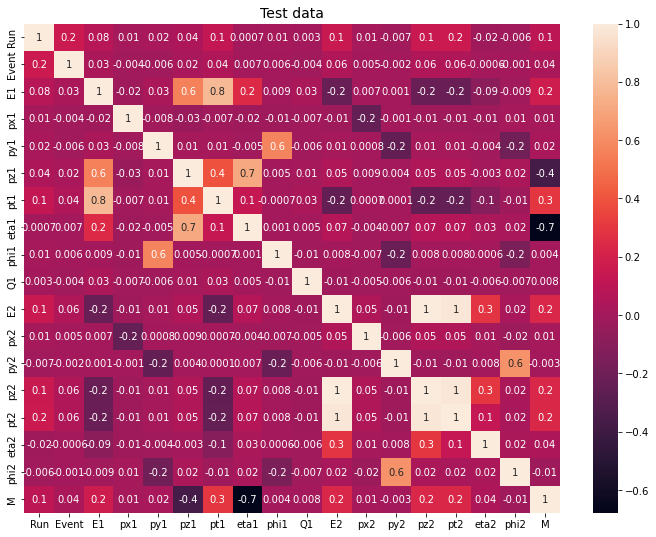

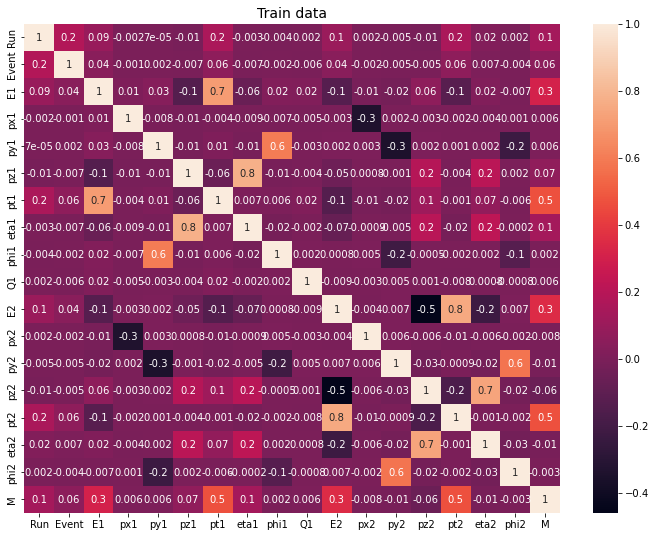

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(check.corr(), annot=True, fmt='.1g')
plt.title('Test data', fontsize = 14)

plt.figure(figsize=(12,9))
sns.heatmap(data.drop(columns='Q2').corr(), annot=True, fmt='.1g')
plt.title('Train data', fontsize = 14)

Кореляция сильно отличается, это странно!

Посмотрим расброс данных

Text(0.5, 0, 'Feature')

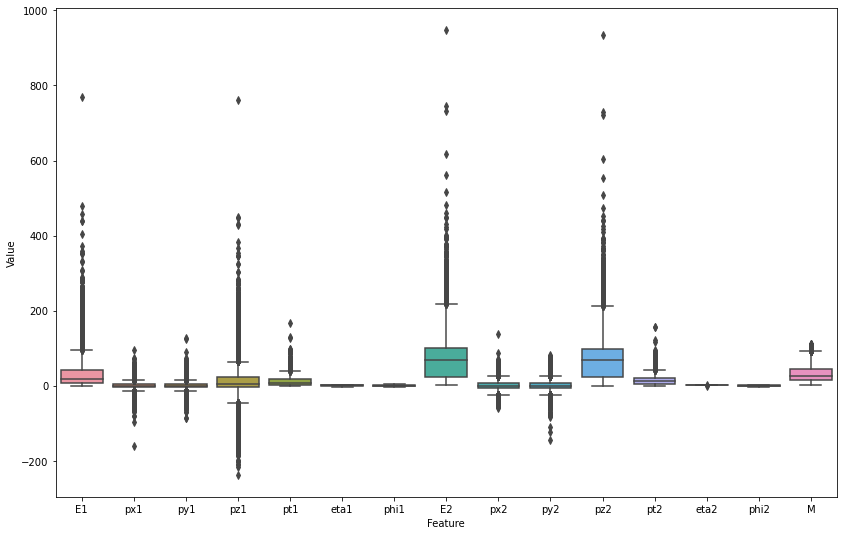

In [ ]:
plt.figure(figsize = (14,9))
sns.boxplot(data = check.drop(columns=['Q1', 'Event', 'Run']))
plt.ylabel('Value')
plt.xlabel('Feature')

Посмотрим на расброс данных по каждому признаку отдельно

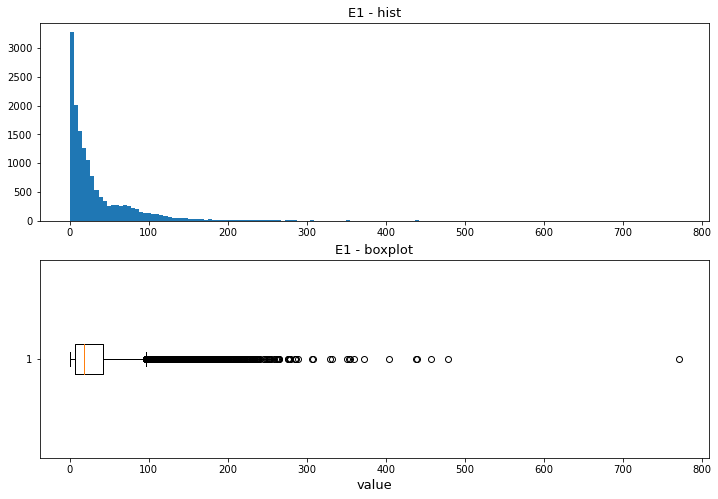

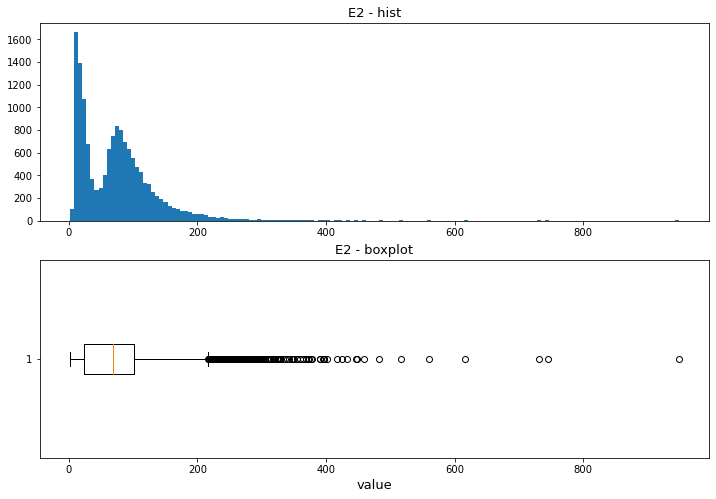

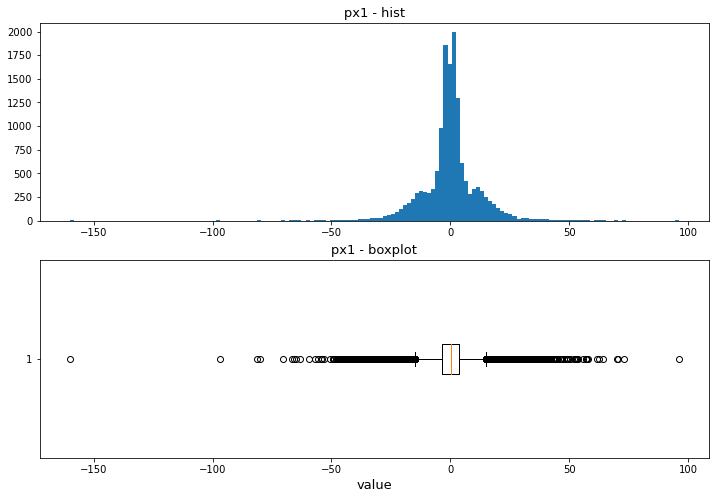

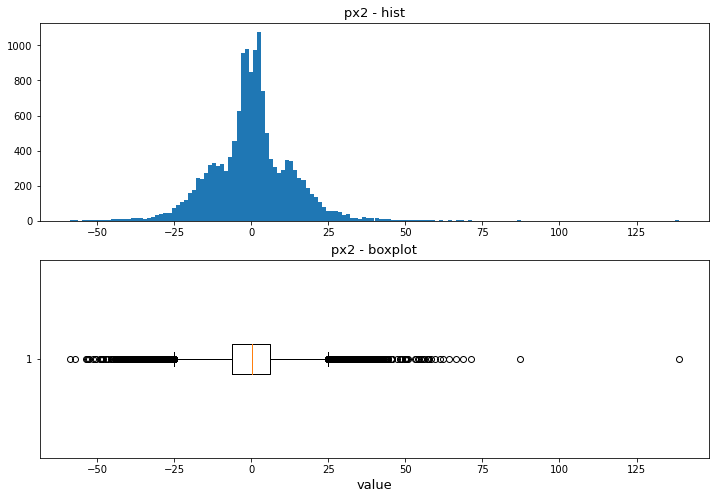

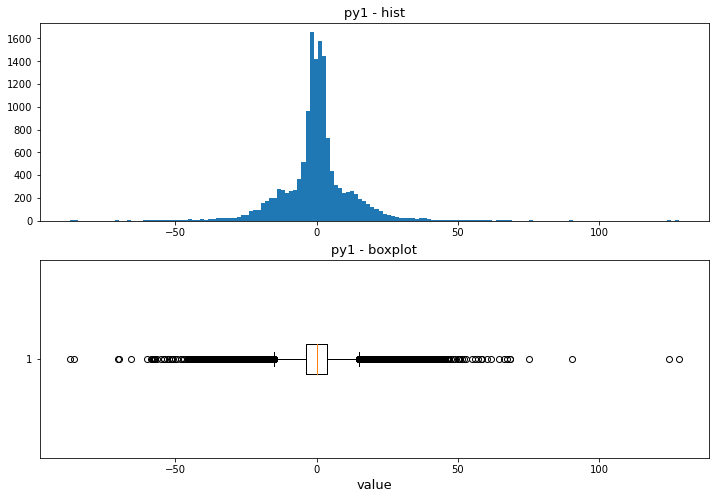

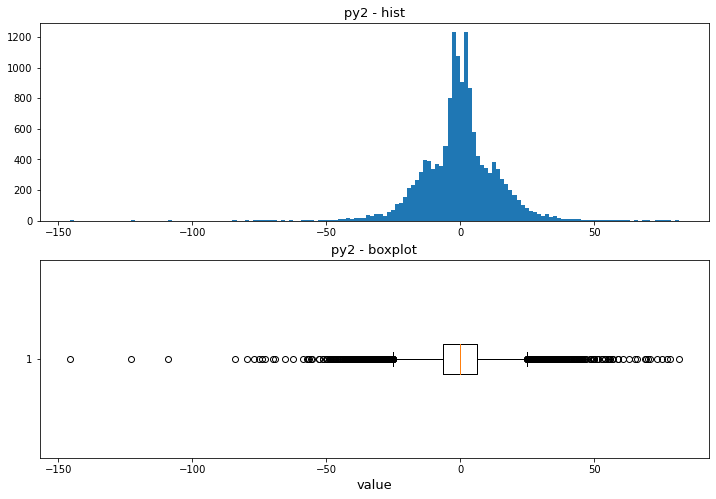

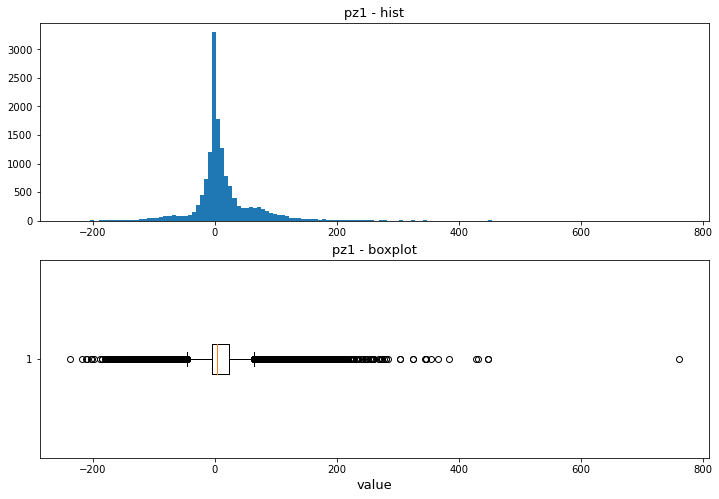

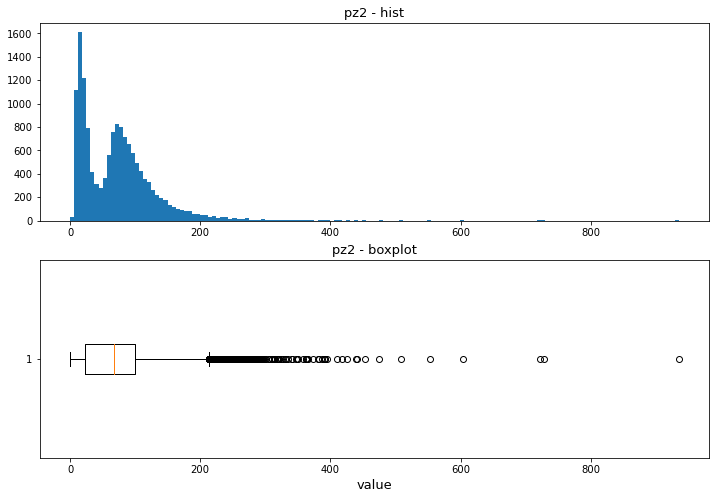

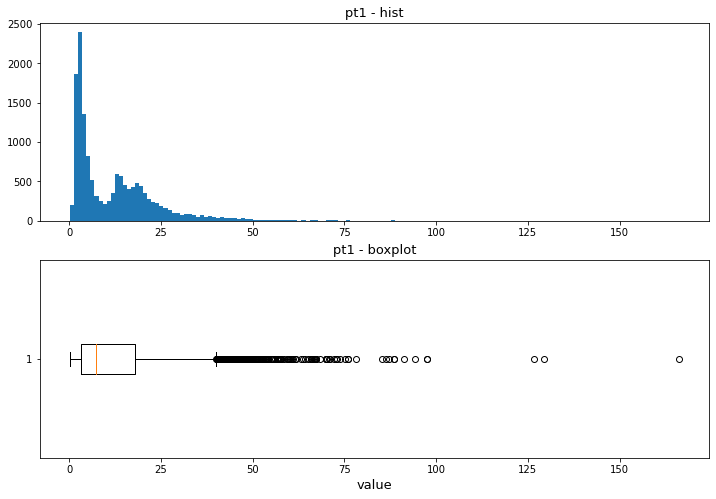

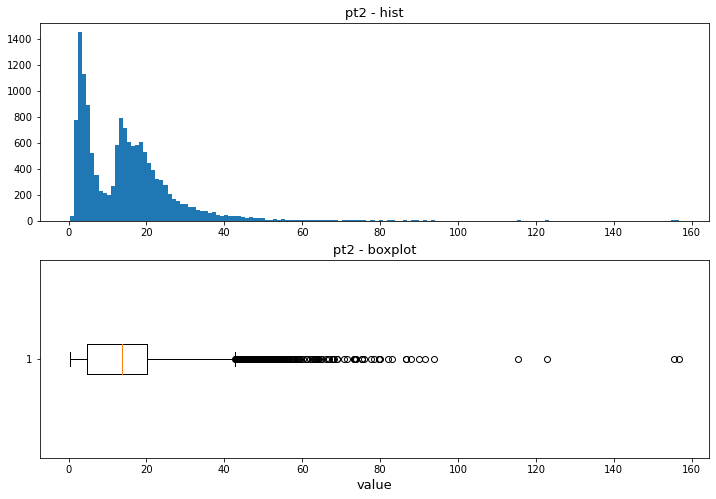

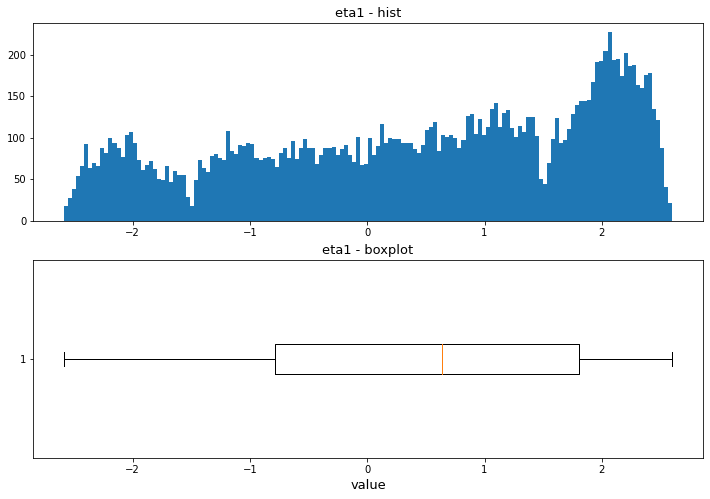

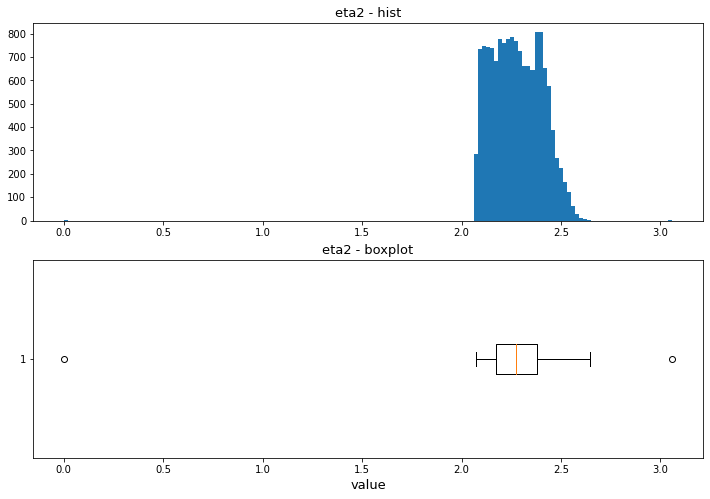

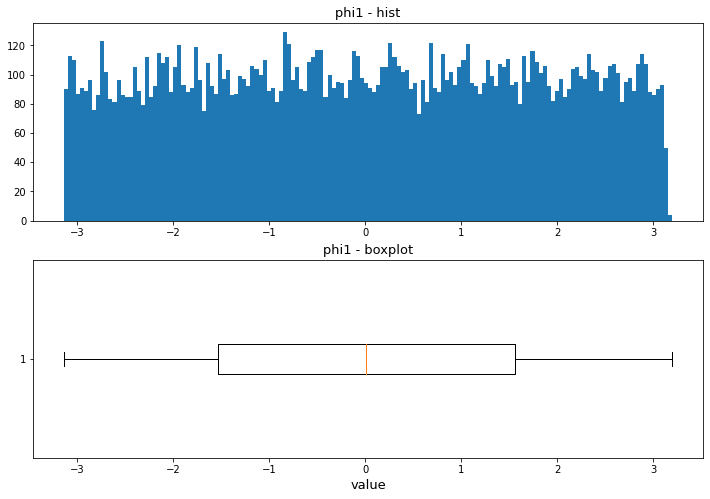

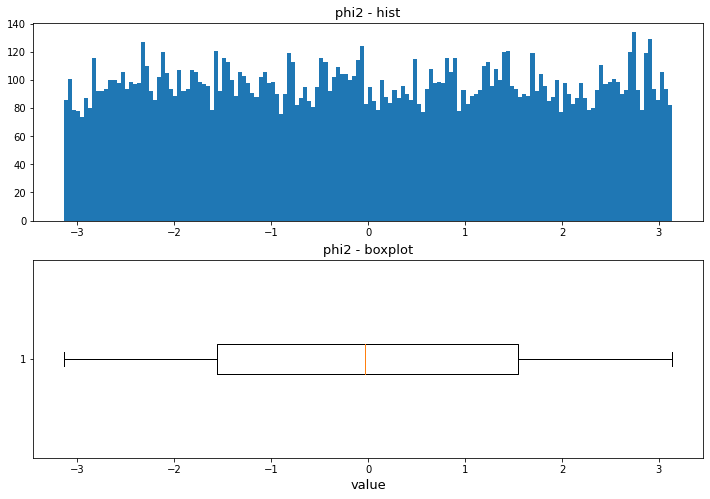

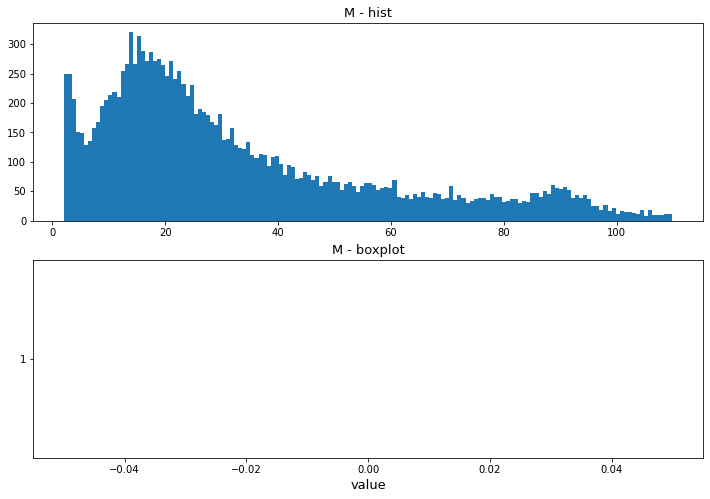

In [ ]:
features = ['E1', 'E2', 'px1', 'px2', 'py1', 'py2', 'pz1', 'pz2', 'pt1', 'pt2', 'eta1', 'eta2', 'phi1', 'phi2', 'M']

for feature in features:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
    
    ax1.hist(check[feature], bins=150)
    ax1.set_title(feature + ' - hist', fontsize=13)  

    ax2.boxplot(check[feature], vert=False) 
    ax2.set_title(feature + ' - boxplot', fontsize=13)
    ax2.set_xlabel('value', fontsize=13) 
    plt.show()

Видим много аномалий, их нужно скорректировать

### Применяем разработанную модель к нашим данным.

? Заполним пропуск в столбце M

In [ ]:
imputed = imputer.fit_transform(check)
check = pd.DataFrame(imputed, columns=check.drop(columns='Event').columns)

In [ ]:
#check.drop(columns = ["Run","Event"], inplace=True)

In [ ]:
check.fillna(-1, inplace=True)

Применяем разработанную модель к нашим данным.

In [ ]:
pred = vc.predict(check)

Обрабатываем данные и сохраняем в файл

In [ ]:
pred = pd.Series(pred)
pred.to_csv('Result.csv')
pred_file = pd.read_csv('Result.csv')
pred_file.rename(columns={'0': 'Q2','Unnamed: 0':'Number'}, inplace=True)
check = check.join(pred_file)
pred_final = check[['Event', 'Q2']]
pred_final.to_csv('Result_final.csv',index=False)